<a href="https://colab.research.google.com/github/yaeliavni/AI/blob/main/LAPD_true_crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA and processing

Parse timestamps → hour, weekday, month, holidays; derive rolling counts (7‑day, 28‑day), “seasonality” flags.

Spatialize: snap lat/long to H3/grid; compute neighbor stats (local mean, recent bursts).

Clean weird coords, coarse addresses, and duplicates; keep a “data issues” log (0°,0° cases and imprecise blocks)

In [1]:
!pip -q install h3==3.7.6 holidays==0.41 dcor==0.6 seaborn==0.13.2 folium==0.17.0

import os, re, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from datetime import datetime
from holidays import US as USHolidays
import dcor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mutual_info_score
from sklearn.cluster import DBSCAN


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.1/913.1 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 8.8 MB/s eta 0:00:00


In [2]:
# ==== USER CONFIG ====
CSV_PATH = "/content/Crime_Data_from_2020_to_Present.csv.zip"
H3_RES   = 8  # ~0.74km2 cells; 8–9 is a good start for city-scale

# LA-ish bounding box to catch weird coords
LAT_MIN, LAT_MAX = 33.2, 34.9
LON_MIN, LON_MAX = -119.2, -117.4

# Unique-threshold for cat/num split
CATEGORICAL_MAX_UNIQUE = 20

# For rolling counts
ROLL_WINDOWS = [7, 28]  # in days
df = pd.read_csv(CSV_PATH, low_memory=False)
df.head()

,DR_NO,Date_Reported,Date_occured,Time_occured,Area,Crime_Code,Victim_age,Victim_sex,Victim_descent,Premis,Weapon,Status,LOCATION,LAT,LON
0,190326475,03/01/20 0:00,03/01/20 0:00,2130,Wilshire,VEHICLE - STOLEN,0,M,O,STREET,NaN,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,02/09/20 0:00,02/08/20 0:00,1800,Central,BURGLARY FROM VEHICLE,47,M,O,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628
2,200320258,11/11/20 0:00,11/04/20 0:00,1700,Southwest,BIKE - STOLEN,19,X,X,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Invest Cont,1400 W 37TH ST,34.0210,-118.3002
3,200907217,05/10/23 0:00,03/10/20 0:00,2037,Van Nuys,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),19,M,O,CLOTHING STORE,NaN,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,Hollywood,THEFT OF IDENTITY,28,M,H,SIDEWALK,NaN,Invest Cont,1900 TRANSIENT,34.0944,-118.3277


In [3]:
df = df.drop('DR_NO', axis=1)

df.head()

,Date_Reported,Date_occured,Time_occured,Area,Crime_Code,Victim_age,Victim_sex,Victim_descent,Premis,Weapon,Status,LOCATION,LAT,LON
0,03/01/20 0:00,03/01/20 0:00,2130,Wilshire,VEHICLE - STOLEN,0,M,O,STREET,NaN,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,02/09/20 0:00,02/08/20 0:00,1800,Central,BURGLARY FROM VEHICLE,47,M,O,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628
2,11/11/20 0:00,11/04/20 0:00,1700,Southwest,BIKE - STOLEN,19,X,X,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Invest Cont,1400 W 37TH ST,34.0210,-118.3002
3,05/10/23 0:00,03/10/20 0:00,2037,Van Nuys,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),19,M,O,CLOTHING STORE,NaN,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387
4,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,Hollywood,THEFT OF IDENTITY,28,M,H,SIDEWALK,NaN,Invest Cont,1900 TRANSIENT,34.0944,-118.3277


In [4]:
def parse_datetime(row):
    # Many LAPD datasets store date and separate HHMM int.
    # Handle strings like "01/31/2020" and time like 1345 (1:45 PM).
    d = row.get("date_occ")
    t = row.get("time_occ")
    if pd.isna(d):
        return pd.NaT
    # try several formats
    for fmt in ("%m/%d/%Y", "%m/%d/%Y %H:%M:%S", "%Y-%m-%d", "%m/%d/%y"):
        try:
            base = pd.to_datetime(d, format=fmt, errors="raise")
            break
        except Exception:
            base = pd.NaT
    if pd.isna(base):
        return pd.NaT
    # time as HHMM integer (e.g., 30, 830, 2230)
    if pd.notna(t):
        try:
            t = int(t)
            hh = int(t // 100)
            mm = int(t % 100)
            base = base + pd.to_timedelta(hh, unit="h") + pd.to_timedelta(mm, unit="m")
        except Exception:
            pass
    return base

df["dt_occ"] = df.apply(parse_datetime, axis=1)
df["date"] = df["dt_occ"].dt.date # Extract the date part here

# seasonality / calendar
us_holidays = USHolidays()  # federal+common
df["hour"] = df["dt_occ"].dt.hour
df["weekday"] = df["dt_occ"].dt.weekday  # 0=Mon
df["month"] = df["dt_occ"].dt.month
df["weekofyear"] = df["dt_occ"].dt.isocalendar().week.astype("Int64")
df["is_weekend"] = df["weekday"].isin([5,6]).astype(int)
df["is_holiday"] = df["date"].isin(pd.to_datetime(list(us_holidays.keys()))).astype(int)
df["dayofyear"] = df["dt_occ"].dt.dayofyear
df["quarter"] = df["dt_occ"].dt.quarter

# simple seasonality tags (feel free to adjust ranges)
df["season"] = pd.cut(df["month"],
                      bins=[0,2,5,8,11,12],
                      labels=["Winter","Spring","Summer","Fall","Winter2"],
                      include_lowest=True)

In [5]:
# FIX: Your date column is empty - let's fix it and regenerate features

print("=== FIXING DATE ISSUES ===\n")

# Check what date columns actually contain data
print("1. Checking available date columns:")
date_columns = ['Date_Reported', 'Date_occured', 'dt_occ', 'date']
for col in date_columns:
    if col in df.columns:
        non_null = df[col].notna().sum()
        print(f"{col}: {non_null} non-null values")
        if non_null > 0:
            print(f"  Sample values: {df[col].dropna().head(3).tolist()}")

# Use dt_occ (which seems to have datetime data) or Date_occured
print("\n2. Using dt_occ as the primary date column:")
if 'dt_occ' in df.columns and df['dt_occ'].notna().sum() > 0:
    # Use dt_occ which is already datetime
    df['date'] = df['dt_occ']
    print("✅ Using dt_occ column")
elif 'Date_occured' in df.columns and df['Date_occured'].notna().sum() > 0:
    # Parse Date_occured
    df['date'] = pd.to_datetime(df['Date_occured'], errors='coerce')
    print("✅ Using Date_occured column")
else:
    print("❌ No valid date columns found!")

# Remove rows with invalid dates
initial_count = len(df)
df = df.dropna(subset=['date'])
print(f"\n3. Filtered dataset: {initial_count} → {len(df)} rows")

# Regenerate time features from the correct date column
print("\n4. Regenerating time features:")
# Fix hour extraction - your hours are all zeros
# If you have a Time_occured column with time info:
if 'Time_occured' in df.columns:
    # Convert time to hours (assuming Time_occured is in HHMM format like 1430 for 2:30 PM)
    df['hour'] = (df['Time_occured'] // 100) % 24
    print(f"Hour range after fix: {df['hour'].min()} to {df['hour'].max()}")
    print(f"Unique hours: {df['hour'].nunique()}")

df['weekday'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Hour range: {df['hour'].min()} to {df['hour'].max()}")
print(f"Weekday range: {df['weekday'].min()} to {df['weekday'].max()}")

print("\n5. ✅ READY TO RERUN YOUR PLOTTING CODE!")

# Test the daily aggregation now
daily_test = df.groupby("date").size()
print(f"\nDaily aggregation now has {len(daily_test)} days of data")
print(f"Sample daily counts:\n{daily_test.head()}")

=== FIXING DATE ISSUES ===

1. Checking available date columns:
Date_Reported: 974477 non-null values
  Sample values: ['03/01/20 0:00', '02/09/20 0:00', '11/11/20 0:00']
Date_occured: 974477 non-null values
  Sample values: ['03/01/20 0:00', '02/08/20 0:00', '11/04/20 0:00']
dt_occ: 0 non-null values
date: 0 non-null values

2. Using dt_occ as the primary date column:
✅ Using Date_occured column

3. Filtered dataset: 974477 → 974477 rows

4. Regenerating time features:
Hour range after fix: 0 to 23
Unique hours: 24
Date range: 2020-01-01 00:00:00 to 2024-09-02 00:00:00
Hour range: 0 to 23
Weekday range: 0 to 6

5. ✅ READY TO RERUN YOUR PLOTTING CODE!

Daily aggregation now has 1707 days of data
Sample daily counts:
date
2020-01-01    1153
2020-01-02     527
2020-01-03     595
2020-01-04     541
2020-01-05     505
dtype: int64


In [6]:
issues = []

# Coerce lat/lon
for c in ("lat","lon"):
    if c in df:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Bad coords: missing or (0,0) or out-of-bounds
bad_zero = ((df["lat"]==0) & (df["lon"]==0)).sum() if {"lat","lon"}.issubset(df.columns) else 0
issues.append({"issue":"zero_zero_coords","count":int(bad_zero)})

bad_bounds = 0
if {"lat","lon"}.issubset(df.columns):
    mask_bounds = ~df["lat"].between(LAT_MIN,LAT_MAX) | ~df["lon"].between(LON_MIN,LON_MAX)
    bad_bounds = mask_bounds.sum()
    issues.append({"issue":"outside_LA_bbox","count":int(bad_bounds)})
    df.loc[mask_bounds | ((df["lat"]==0)&(df["lon"]==0)), ["lat","lon"]] = np.nan

# Coarse/odd addresses (very dataset-dependent; here we flag obviously imprecise strings)
addr_issues = 0
if "address" in df:
    coarse_mask = df["address"].astype(str).str.contains(r"\b\d{1,3}00\s+BLK\b", case=False, na=False)
    addr_issues = coarse_mask.sum()
    issues.append({"issue":"coarse_block_addresses","count":int(addr_issues)})

# Duplicates by DR number (if present)
dups = 0
if "dr_no" in df:
    dups = df["dr_no"].duplicated(keep=False).sum()
    issues.append({"issue":"duplicate_DR_NO_rows","count":int(dups)})

issues_log = pd.DataFrame(issues)
issues_log


,issue,count
0,zero_zero_coords,0


In [7]:
"""from h3 import h3

# Generate H3 index from LAT and LON
if {"LAT", "LON"}.issubset(df.columns):
    # Ensure LAT and LON are numeric and handle potential NaNs
    df["LAT"] = pd.to_numeric(df["LAT"], errors="coerce")
    df["LON"] = pd.to_numeric(df["LON"], errors="coerce")

    # Generate h3 index, handling NaNs in LAT/LON
    df["h3"] = df.apply(
        lambda row: h3.geo_to_h3(row["LAT"], row["LON"], H3_RES)
        if pd.notna(row["LAT"]) and pd.notna(row["LON"])
        else None,
        axis=1,
    )
    print(f"Generated H3 index at resolution {H3_RES}")
else:
    print("LAT or LON column not found. Cannot generate H3 index.")
    # Create an empty h3 column to prevent further errors if LAT/LON are missing
    df["h3"] = None


# --- Daily counts per cell (with continuous dates) ---
cell_daily = (
    df.dropna(subset=["h3","date"])
      .groupby(["h3","date"])
      .size()
      .rename("cnt")
      .reset_index()
)

# For correct rolling windows: reindex each cell onto its full date range (fill missing days with 0)
def make_continuous(g):
    idx = pd.date_range(g["date"].min(), g["date"].max(), freq="D")
    g2 = g.set_index("date").reindex(idx).fillna(0.0).rename_axis("date").reset_index()
    g2["h3"] = g["h3"].iloc[0]
    return g2[["h3","date","cnt"]]

cell_daily = (
    cell_daily.groupby("h3", group_keys=False).apply(make_continuous).reset_index(drop=True)
)

# Rolling features per cell (7d/28d sums)
cell_daily = cell_daily.sort_values(["h3","date"])
for w in ROLL_WINDOWS:
    cell_daily[f"roll_{w}d"] = cell_daily.groupby("h3")["cnt"].transform(
        lambda s: s.rolling(window=w, min_periods=1).sum()
    )

# --- Neighbor stats & burstiness ---
def neighbor_stats(cell_daily, k=1):
    unique_cells = cell_daily["h3"].unique().tolist()
    # k_ring returns a set; use set subtraction to drop self
    neigh_map = {c: list(h3.k_ring(c, k) - {c}) if c == c else [] for c in unique_cells}

    # Pivot date x h3 for fast neighbor means
    pivot = cell_daily.pivot_table(index="date", columns="h3", values="cnt", aggfunc="sum").fillna(0)

    # Compute neighbor mean per column
    neighbor_mean_cols = {}
    cols = pivot.columns
    for c in cols:
        neighs = [n for n in neigh_map.get(c, []) if n in cols]
        if len(neighs) == 0:
            neighbor_mean_cols[c] = pd.Series(0, index=pivot.index)
        else:
            neighbor_mean_cols[c] = pivot[neighs].mean(axis=1)

    neighbor_mean_df = pd.DataFrame(neighbor_mean_cols)
    # FIX: After stacking, 'h3' becomes level 1, not a column
    neighbor_mean_df = (
        neighbor_mean_df.stack()
        .rename("neighbor_mean")
        .reset_index()
        .rename(columns={"level_0": "date", "level_1": "h3"})
    )
    neighbor_mean_df["date"] = pd.to_datetime(neighbor_mean_df["date"])

    out = cell_daily.merge(neighbor_mean_df, on=["date","h3"], how="left")
    out["burstiness"] = out["cnt"] / (1.0 + out["neighbor_mean"])
    return out
cell_daily = neighbor_stats(cell_daily, k=1)

# Attach back to row level (by [h3, date])
df = df.merge(cell_daily, on=["h3","date"], how="left", suffixes=("", "_cell"))
df.head(3)"""

'from h3 import h3\n\n# Generate H3 index from LAT and LON\nif {"LAT", "LON"}.issubset(df.columns):\n    # Ensure LAT and LON are numeric and handle potential NaNs\n    df["LAT"] = pd.to_numeric(df["LAT"], errors="coerce")\n    df["LON"] = pd.to_numeric(df["LON"], errors="coerce")\n\n    # Generate h3 index, handling NaNs in LAT/LON\n    df["h3"] = df.apply(\n        lambda row: h3.geo_to_h3(row["LAT"], row["LON"], H3_RES)\n        if pd.notna(row["LAT"]) and pd.notna(row["LON"])\n        else None,\n        axis=1,\n    )\n    print(f"Generated H3 index at resolution {H3_RES}")\nelse:\n    print("LAT or LON column not found. Cannot generate H3 index.")\n    # Create an empty h3 column to prevent further errors if LAT/LON are missing\n    df["h3"] = None\n\n\n# --- Daily counts per cell (with continuous dates) ---\ncell_daily = (\n    df.dropna(subset=["h3","date"])\n      .groupby(["h3","date"])\n      .size()\n      .rename("cnt")\n      .reset_index()\n)\n\n# For correct rolling win

In [8]:
# ====== NAN HANDLING (DOMAIN-AWARE) ======

# 0) helper: safe-exists
def has(c): return c in df.columns

# 1) engineered spatio-temporal features → true zeros (absence of events)
for c in ["cnt","roll_7d","roll_28d","neighbor_mean","burstiness"]:
    if has(c):
        df[c] = df[c].fillna(0.0)

# 2) time fields
# hour may be NA if Time_occured missing → encode as -1 and keep a flag
if has("hour"):
    df["hour_missing"] = df["hour"].isna().astype(int)
    df["hour"] = df["hour"].fillna(-1).astype(int)

# weekday/month/etc. should exist; if not, regenerate from date
if has("date"):
    for c, fn in {
        "weekday": df["date"].dt.weekday,
        "month":   df["date"].dt.month,
        "dayofyear": df["date"].dt.dayofyear,
        "quarter": df["date"].dt.quarter
    }.items():
        if not has(c):
            df[c] = fn
    # holiday/weekend flags default to 0 if missing
    for c in ["is_weekend","is_holiday"]:
        if has(c):
            df[c] = df[c].fillna(0).astype(int)

# 3) victim age cleanup → cap to plausible range, then hierarchical median impute
if has("victim_age"):
    # invalid ages to NaN
    df["victim_age"] = pd.to_numeric(df["victim_age"], errors="coerce")
    df.loc[(df["victim_age"] < 0) | (df["victim_age"] > 110), "victim_age"] = np.nan
    df["victim_age_missing"] = df["victim_age"].isna().astype(int)

    # build coarse crime bucket to use in grouping (e.g., 100s)
    crime_bucket = None
    if has("crime_code"):
        cc = pd.to_numeric(df["crime_code"], errors="coerce")
        crime_bucket = (cc // 100).astype("Int64")

    # hierarchical fill: (sex + crime_bucket) → (sex) → global
    if has("victim_sex") and crime_bucket is not None:
        grp_med = df.groupby(["victim_sex", crime_bucket])["victim_age"].transform("median")
        df["victim_age"] = df["victim_age"].fillna(grp_med)
    if has("victim_sex"):
        grp_med2 = df.groupby("victim_sex")["victim_age"].transform("median")
        df["victim_age"] = df["victim_age"].fillna(grp_med2)
    df["victim_age"] = df["victim_age"].fillna(df["victim_age"].median())

# 4) location: coords may be missing by design → keep NaN, add flags (don’t fabricate)
for c in ["lat","lon"]:
    if has(c):
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[f"{c}_missing"] = df[c].isna().astype(int)

# Optional: try to infer H3 for rows missing it from modal H3 of the same area_name (safe-ish fallback)
if has("h3"):
    df["h3_missing"] = df["h3"].isna().astype(int)
    if has("area_name"):
        mode_by_area = (
            df.dropna(subset=["h3","area_name"])
              .groupby("area_name")["h3"]
              .agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)
        )
        # only fill H3 where area_name has a very dominant mode (avoid noisy fill)
        area_counts = (df.groupby("area_name")["h3"].nunique())
        strong_areas = area_counts[area_counts == 1].index  # area maps to a single H3 (rare), or tighten as needed
        mask = df["h3"].isna() & df["area_name"].isin(strong_areas)
        df.loc[mask, "h3"] = df.loc[mask, "area_name"].map(mode_by_area)

# 5) categorical codes → explicit "Unknown" + missing flags (keeps info without dropping rows)
cat_fill = ["crime_desc","premise_desc","weapon_desc","victim_sex","victim_descent","area_name"]
for c in cat_fill:
    if has(c):
        df[f"{c}_missing"] = df[c].isna().astype(int)
        df[c] = df[c].fillna("Unknown")

# 6) status / text address — keep “Unknown” to avoid losing rows
for c in ["status","address","LOCATION","location"]:
    if has(c):
        df[f"{c}_missing"] = df[c].isna().astype(int)
        df[c] = df[c].fillna("Unknown")

# 7) modeling-friendly list of numeric/categorical after imputations
num_cols_model = sorted(list(df.select_dtypes(include=[np.number]).columns))
cat_cols_model = sorted([c for c in df.columns if df[c].dtype == "object"])

print("✅ NaN handling done.")
print("Numeric (sample):", num_cols_model[:10], "… total", len(num_cols_model))
print("Categorical (sample):", cat_cols_model[:10], "… total", len(cat_cols_model))


✅ NaN handling done.
Numeric (sample): ['LAT', 'LOCATION_missing', 'LON', 'Time_occured', 'Victim_age', 'dayofyear', 'hour', 'hour_missing', 'is_holiday', 'is_weekend'] … total 14
Categorical (sample): ['Area', 'Crime_Code', 'Date_Reported', 'Date_occured', 'LOCATION', 'Premis', 'Status', 'Victim_descent', 'Victim_sex', 'Weapon'] … total 10


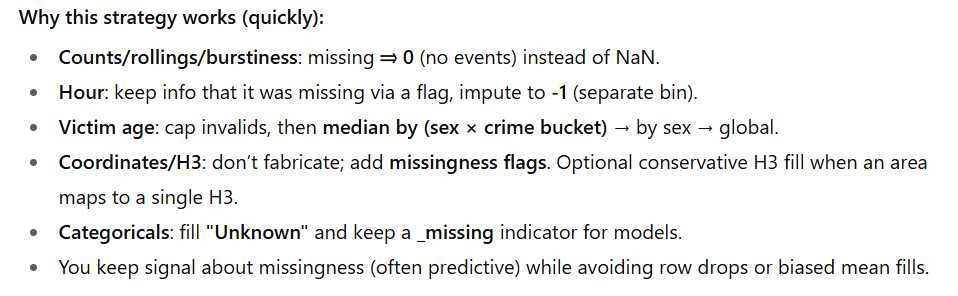

In [9]:
# classify by unique-count rule
num_cols, cat_cols = [], []
for c in df.columns:
    if df[c].dtype.kind in "biufc" and df[c].nunique(dropna=True) > CATEGORICAL_MAX_UNIQUE:
        num_cols.append(c)
    elif df[c].dtype.kind in "O" or df[c].nunique(dropna=True) <= CATEGORICAL_MAX_UNIQUE:
        # treat string-ish or low-unique as categorical
        cat_cols.append(c)

# basic hygiene: drop obvious IDs from modeling features later
id_like = [c for c in ["dr_no"] if c in df.columns]
print("Numerical:", num_cols[:12], "... (total", len(num_cols),")")
print("Categorical:", cat_cols[:12], "... (total", len(cat_cols),")")

# optional one-hot: only for *low-card* categoricals to avoid explosion
LOW_CARD_MAX = 30
low_card = [c for c in cat_cols if df[c].nunique(dropna=True) <= LOW_CARD_MAX]
df_oh = pd.get_dummies(df, columns=low_card, dummy_na=True, drop_first=False)
df_oh.shape


Numerical: ['Time_occured', 'Victim_age', 'LAT', 'LON', 'hour'] ... (total 5 )
Categorical: ['Date_Reported', 'Date_occured', 'Area', 'Crime_Code', 'Victim_sex', 'Victim_descent', 'Premis', 'Weapon', 'Status', 'LOCATION', 'dt_occ', 'weekday'] ... (total 21 )


(974477, 108)

In [10]:
"""# 7.1 Pearson/Spearman on numerics - not interesting at all, it was clearly just very obvious correlations
num_used = [c for c in num_cols if c not in id_like]
num_df = df[num_used].select_dtypes(include=[np.number]).dropna(axis=1, how="all")

plt.figure(figsize=(10,7))
sns.heatmap(num_df.corr(method="pearson"), cmap="coolwarm", center=0)
plt.title("Pearson correlation (numeric)")
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(num_df.corr(method="spearman"), cmap="coolwarm", center=0)
plt.title("Spearman correlation (numeric)")
plt.show()"""
"""
# 7.2 Distance correlation (numeric) - also, no interesting results
def distance_corr_matrix(X: pd.DataFrame):
    cols = X.columns
    n = len(cols)
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            xi = X[cols[i]].to_numpy()
            xj = X[cols[j]].to_numpy()
            mask = ~np.isnan(xi) & ~np.isnan(xj)
            dc = dcor.distance_correlation(xi[mask], xj[mask]) if mask.sum()>3 else np.nan
            M[i,j]=M[j,i]=dc
    return pd.DataFrame(M, index=cols, columns=cols)

dc_mat = distance_corr_matrix(num_df.sample(min(8000, len(num_df)), random_state=42))
plt.figure(figsize=(10,7))
sns.heatmap(dc_mat, cmap="viridis")
plt.title("Distance correlation (numeric, non-linear)")
plt.show()"""

'\n# 7.2 Distance correlation (numeric) - also, no interesting results\ndef distance_corr_matrix(X: pd.DataFrame):\n    cols = X.columns\n    n = len(cols)\n    M = np.zeros((n,n))\n    for i in range(n):\n        for j in range(i, n):\n            xi = X[cols[i]].to_numpy()\n            xj = X[cols[j]].to_numpy()\n            mask = ~np.isnan(xi) & ~np.isnan(xj)\n            dc = dcor.distance_correlation(xi[mask], xj[mask]) if mask.sum()>3 else np.nan\n            M[i,j]=M[j,i]=dc\n    return pd.DataFrame(M, index=cols, columns=cols)\n\ndc_mat = distance_corr_matrix(num_df.sample(min(8000, len(num_df)), random_state=42))\nplt.figure(figsize=(10,7))\nsns.heatmap(dc_mat, cmap="viridis")\nplt.title("Distance correlation (numeric, non-linear)")\nplt.show()'

In [11]:
# 7.3 Cramér’s V for categorical
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    if ct.empty: # Add this check
        return np.nan # Return NaN if crosstab is empty
    chi2 = pd.api.types.CategoricalDtype
    from scipy.stats import chi2_contingency
    chi2, p, dof, exp = chi2_contingency(ct, correction=False)
    n = ct.sum().sum()
    phi2 = chi2 / n
    r, k = ct.shape
    # bias correction
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / max((kcorr-1), (rcorr-1)))

from itertools import combinations
cats_small = [c for c in cat_cols if df[c].nunique(dropna=True) <= 50]
cv_pairs = {}
for a, b in combinations(cats_small, 2):
    v = cramers_v(df[a], df[b])
    cv_pairs[(a,b)] = v

# show top associations
sorted_cv = sorted(cv_pairs.items(), key=lambda kv: kv[1], reverse=True)[:20]
sorted_cv[:10]

[(('Area', 'dt_occ'), nan),
 (('Area', 'weekofyear'), nan),
 (('Area', 'dayofyear'), nan),
 (('Area', 'quarter'), nan),
 (('Area', 'season'), nan),
 (('Victim_sex', 'Victim_descent'), np.float64(0.2722408955621365)),
 (('Area', 'Victim_descent'), np.float64(0.1218081414286508)),
 (('Victim_sex', 'Status'), np.float64(0.053856452521417277)),
 (('Area', 'Victim_sex'), np.float64(0.045102444961214905)),
 (('Area', 'Status'), np.float64(0.027291521815220102))]

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
# from joblib import Parallel, delayed  # optional

def discretize_columns(df, n_bins=10):
    """Return dict of integer-coded columns (-1 denotes NaN)."""
    codes = {}
    for c in df.columns:
        s = df[c]
        if pd.api.types.is_numeric_dtype(s):
            # cut once; labels=False gives integer bin IDs
            binned = pd.cut(s, bins=n_bins, duplicates="drop", labels=False)
            codes[c] = binned.astype("float64")  # will have NaN
        else:
            # category codes: unseen/missing -> -1
            cat = s.astype("category")
            codes[c] = cat.cat.codes.replace(-1, np.nan).astype("float64")
    return codes

def mi_pair_from_codes(x_codes, y_codes, min_n=50):
    mask = (~np.isnan(x_codes)) & (~np.isnan(y_codes))
    if mask.sum() < min_n:
        return np.nan
    # cast to int for mutual_info_score
    return mutual_info_score(x_codes[mask].astype(int), y_codes[mask].astype(int))

# ---- Precompute once ----
n_bins = 10
codes = discretize_columns(df, n_bins=n_bins)

targets = ["hour","weekday","month","is_weekend","is_holiday"]
targets = [t for t in targets if t in df.columns]

mi_rows = []
for t in targets:
    y = codes[t].values
    for f in df.columns:
        if f == t:
            continue
        x = codes[f].values
        mi = mi_pair_from_codes(x, y, min_n=50)
        mi_rows.append((t, f, mi))

mi_df = pd.DataFrame(mi_rows, columns=["target","feature","MI"])
mi_df = (mi_df
         .sort_values(["target","MI"], ascending=[True, False])
         .groupby("target", as_index=False)
         .head(10))
mi_df

,target,feature,MI
2,hour,Time_occured,2.027451
11,hour,LOCATION,0.327419
4,hour,Crime_Code,0.050936
8,hour,Premis,0.034272
1,hour,Date_occured,0.018063
15,hour,date,0.018063
0,hour,Date_Reported,0.014122
9,hour,Weapon,0.010746
5,hour,Victim_age,0.006400
16,hour,weekday,0.002498


In [13]:
# Debug your empty graphs - run these checks step by step

print("=== DEBUGGING EMPTY GRAPHS ===\n")

# 1. Check your DataFrame basics
print("1. DataFrame Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}\n")

# 2. Check date column specifically
print("2. Date Column Analysis:")
if "date" in df.columns:
    print(f"Date column type: {df['date'].dtype}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Non-null dates: {df['date'].notna().sum()} / {len(df)}")
    print(f"Sample dates: {df['date'].dropna().head(3).tolist()}")
else:
    print("❌ NO 'date' COLUMN FOUND!")
    print("Available columns:", df.columns.tolist())

# 3. Check the daily aggregation
print("\n3. Daily Aggregation Check:")
try:
    daily_test = df.groupby("date").size()
    print(f"Daily counts shape: {daily_test.shape}")
    print(f"Sample daily counts:\n{daily_test.head()}")
    if daily_test.empty:
        print("❌ Daily aggregation is EMPTY!")
    else:
        print(f"✅ Daily aggregation has {len(daily_test)} days")
except Exception as e:
    print(f"❌ Error in daily aggregation: {e}")

# 4. Check ROLL_WINDOWS variable
print("\n4. Rolling Windows Check:")
try:
    print(f"ROLL_WINDOWS: {ROLL_WINDOWS}")
except NameError:
    print("❌ ROLL_WINDOWS is not defined!")
    print("Try: ROLL_WINDOWS = [7, 28]")

# 5. Check for weekday/hour columns
print("\n5. Time Feature Check:")
required_time_cols = ['weekday', 'hour']
for col in required_time_cols:
    if col in df.columns:
        print(f"✅ {col}: {df[col].nunique()} unique values, range: {df[col].min()}-{df[col].max()}")
    else:
        print(f"❌ Missing {col} column")

# 6. Check pivot table data
print("\n6. Pivot Table Check:")
try:
    if 'weekday' in df.columns and 'hour' in df.columns:
        # Try to find a suitable value column
        value_col = "dr_no" if "dr_no" in df else df.select_dtypes(include=['number']).columns[0]
        print(f"Using value column: {value_col}")
        pivot_test = df.pivot_table(index="weekday", columns="hour", values=value_col, aggfunc="count")
        print(f"Pivot shape: {pivot_test.shape}")
        print(f"Pivot has data: {not pivot_test.empty}")
        if not pivot_test.empty:
            print(f"Sample pivot data:\n{pivot_test.iloc[:3, :3]}")
    else:
        print("❌ Missing weekday or hour columns for pivot")
except Exception as e:
    print(f"❌ Pivot error: {e}")

# 7. Quick fix suggestions
print("\n=== QUICK FIXES ===")

# Fix 1: Check if date needs parsing
if "date" in df.columns and df['date'].dtype == 'object':
    print("\n🔧 FIX 1 - Parse dates:")
    print("df['date'] = pd.to_datetime(df['date'])")

# Fix 2: Create time features if missing
if 'weekday' not in df.columns or 'hour' not in df.columns:
    print("\n🔧 FIX 2 - Create time features:")
    print("df['weekday'] = df['date'].dt.weekday")
    print("df['hour'] = df['date'].dt.hour")

# Fix 3: Define rolling windows if missing
print("\n🔧 FIX 3 - Define rolling windows:")
print("ROLL_WINDOWS = [7, 28]")

# Fix 4: Filter out null dates
print("\n🔧 FIX 4 - Filter null dates:")
print("df = df.dropna(subset=['date'])")

print("\n=== RUN THESE FIXES, THEN TRY YOUR PLOTTING CODE AGAIN ===")

=== DEBUGGING EMPTY GRAPHS ===

1. DataFrame Info:
Shape: (974477, 27)
Columns: ['Date_Reported', 'Date_occured', 'Time_occured', 'Area', 'Crime_Code', 'Victim_age', 'Victim_sex', 'Victim_descent', 'Premis', 'Weapon', 'Status', 'LOCATION', 'LAT', 'LON', 'dt_occ', 'date', 'hour', 'weekday', 'month', 'weekofyear', 'is_weekend', 'is_holiday', 'dayofyear', 'quarter', 'season', 'hour_missing', 'LOCATION_missing']
Data types:
Date_Reported               object
Date_occured                object
Time_occured                 int64
Area                        object
Crime_Code                  object
Victim_age                   int64
Victim_sex                  object
Victim_descent              object
Premis                      object
Weapon                      object
Status                      object
LOCATION                    object
LAT                        float64
LON                        float64
dt_occ              datetime64[ns]
date                datetime64[ns]
hour            

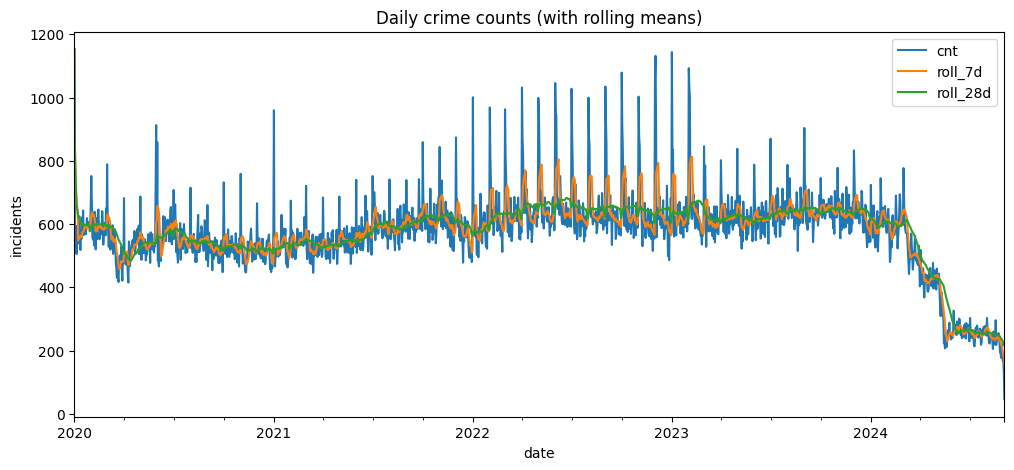

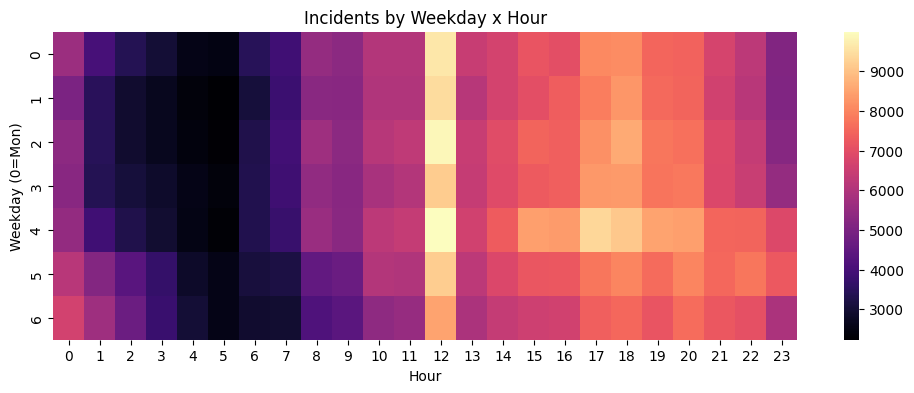

In [14]:
# Time series: daily total + rolling
daily = df.groupby("date").size().rename("cnt").to_frame()
for w in ROLL_WINDOWS:
    daily[f"roll_{w}d"] = daily["cnt"].rolling(w, min_periods=1).mean()

ax = daily.plot(figsize=(12,5), title="Daily crime counts (with rolling means)")
ax.set_ylabel("incidents"); plt.show()

# Hour vs Weekday heatmap
pivot_hw = df.pivot_table(index="weekday", columns="hour", values="dr_no" if "dr_no" in df else df.columns[0], aggfunc="count")
plt.figure(figsize=(12,4))
if not pivot_hw.empty:
    sns.heatmap(pivot_hw, cmap="magma")
    plt.title("Incidents by Weekday x Hour"); plt.xlabel("Hour"); plt.ylabel("Weekday (0=Mon)")
    plt.show()
else:
    print("No data to display Weekday x Hour heatmap.")


# Top crime descriptions (if available)
if "crime_desc" in df:
    top_desc = (df["crime_desc"].value_counts().head(20)).sort_values()
    top_desc.plot(kind="barh", figsize=(8,8), title="Top 20 Crime Descriptions")
    plt.xlabel("count"); plt.show()

# Simple map: sample of hex cells (centroids) colored by recent counts
if "h3" in df and df["h3"].notna().any():
    last_90 = df[df["date"] >= (df["date"].max() - pd.Timedelta(days=90))]
    c90 = last_90.groupby("h3").size().rename("cnt").reset_index()
    # center map around mean lat/lon of valid points
    center_lat = df["lat"].dropna().mean() if "lat" in df else 34.05
    center_lon = df["lon"].dropna().mean() if "lon" in df else -118.25
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)
    for _, row in c90.iterrows():
        # draw hex boundary
        poly = h3.h3_to_geo_boundary(row["h3"], geo_json=True)
        folium.Polygon(locations=poly, weight=1, fill=True, fill_opacity=0.4,
                       tooltip=f'H3 {row["h3"]} | 90d cnt={int(row["cnt"])}').add_to(m)
    m

In [15]:
# 9.1 Z-score outliers on chosen numeric columns
Z_NUMS = [c for c in ["victim_age","cnt","roll_7d","roll_28d","burstiness","lat","lon"] if c in df.columns]
z_flags = pd.Series(False, index=df.index)
for c in Z_NUMS:
    s = df[c].astype(float)
    mu, sd = s.mean(), s.std(ddof=1)
    if not np.isfinite(mu) or sd==0 or s.isna().all():
        continue
    z = (s - mu) / sd
    z_flags = z_flags | (np.abs(z) > 3.0)  # “3-sigma” heuristic

df["outlier_z"] = z_flags.astype(int)

# 9.2 IQR rule for the same columns
iqr_flags = pd.Series(False, index=df.index)
for c in Z_NUMS:
    s = df[c].astype(float).dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_flags = iqr_flags | (df[c] < lo) | (df[c] > hi)

df["outlier_iqr"] = iqr_flags.astype(int)

# 9.3 DBSCAN on spatial coords (find isolated points)
if {"lat","lon"}.issubset(df.columns):
    # sample for speed if huge
    samp_idx = df[["lat","lon"]].dropna().index
    if len(samp_idx) > 200000:
        samp_idx = np.random.default_rng(42).choice(samp_idx, size=200000, replace=False)
    coords = df.loc[samp_idx, ["lat","lon"]].to_numpy()

    # eps in degrees (~300m); tweak as needed
    db = DBSCAN(eps=0.003, min_samples=10, n_jobs=-1)
    labels = db.fit_predict(coords)
    spatial_outliers = pd.Series(0, index=df.index)
    spatial_outliers.loc[samp_idx] = (labels==-1).astype(int)
    df["outlier_dbscan_spatial"] = spatial_outliers
else:
    df["outlier_dbscan_spatial"] = 0

# Composite flag (any method)
df["outlier_any"] = ((df["outlier_z"]==1) | (df["outlier_iqr"]==1) | (df["outlier_dbscan_spatial"]==1)).astype(int)

df[["outlier_z","outlier_iqr","outlier_dbscan_spatial","outlier_any"]].mean().rename("share_of_rows_flagged")


,share_of_rows_flagged
outlier_z,0.0
outlier_iqr,0.0
outlier_dbscan_spatial,0.0
outlier_any,0.0


In [16]:
# 9.1 Z-score outliers on chosen numeric columns
Z_NUMS = [c for c in ["victim_age","cnt","roll_7d","roll_28d","burstiness","lat","lon"] if c in df.columns]
z_flags = pd.Series(False, index=df.index)
for c in Z_NUMS:
    s = df[c].astype(float)
    mu, sd = s.mean(), s.std(ddof=1)
    if not np.isfinite(mu) or sd==0 or s.isna().all():
        continue
    z = (s - mu) / sd
    z_flags = z_flags | (np.abs(z) > 3.0)  # “3-sigma” heuristic

df["outlier_z"] = z_flags.astype(int)

# 9.2 IQR rule for the same columns
iqr_flags = pd.Series(False, index=df.index)
for c in Z_NUMS:
    s = df[c].astype(float).dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_flags = iqr_flags | (df[c] < lo) | (df[c] > hi)

df["outlier_iqr"] = iqr_flags.astype(int)

# 9.3 DBSCAN on spatial coords (find isolated points)
if {"lat","lon"}.issubset(df.columns):
    # sample for speed if huge
    samp_idx = df[["lat","lon"]].dropna().index
    if len(samp_idx) > 200000:
        samp_idx = np.random.default_rng(42).choice(samp_idx, size=200000, replace=False)
    coords = df.loc[samp_idx, ["lat","lon"]].to_numpy()

    # eps in degrees (~300m); tweak as needed
    db = DBSCAN(eps=0.003, min_samples=10, n_jobs=-1)
    labels = db.fit_predict(coords)
    spatial_outliers = pd.Series(0, index=df.index)
    spatial_outliers.loc[samp_idx] = (labels==-1).astype(int)
    df["outlier_dbscan_spatial"] = spatial_outliers
else:
    df["outlier_dbscan_spatial"] = 0

# Composite flag (any method)
df["outlier_any"] = ((df["outlier_z"]==1) | (df["outlier_iqr"]==1) | (df["outlier_dbscan_spatial"]==1)).astype(int)

df[["outlier_z","outlier_iqr","outlier_dbscan_spatial","outlier_any"]].mean().rename("share_of_rows_flagged")

,share_of_rows_flagged
outlier_z,0.0
outlier_iqr,0.0
outlier_dbscan_spatial,0.0
outlier_any,0.0


=== DISTRIBUTION ANALYSIS ===

Found 11 categorical columns: ['Date_Reported', 'Date_occured', 'Area', 'Crime_Code', 'Victim_sex', 'Victim_descent', 'Premis', 'Weapon', 'Status', 'LOCATION', 'season']
Found 16 numerical columns: ['Victim_age', 'LAT', 'LON', 'hour', 'weekday', 'month', 'is_weekend', 'is_holiday', 'dayofyear', 'quarter', 'hour_missing', 'LOCATION_missing', 'outlier_z', 'outlier_iqr', 'outlier_dbscan_spatial', 'outlier_any']

1. CATEGORICAL DISTRIBUTIONS:


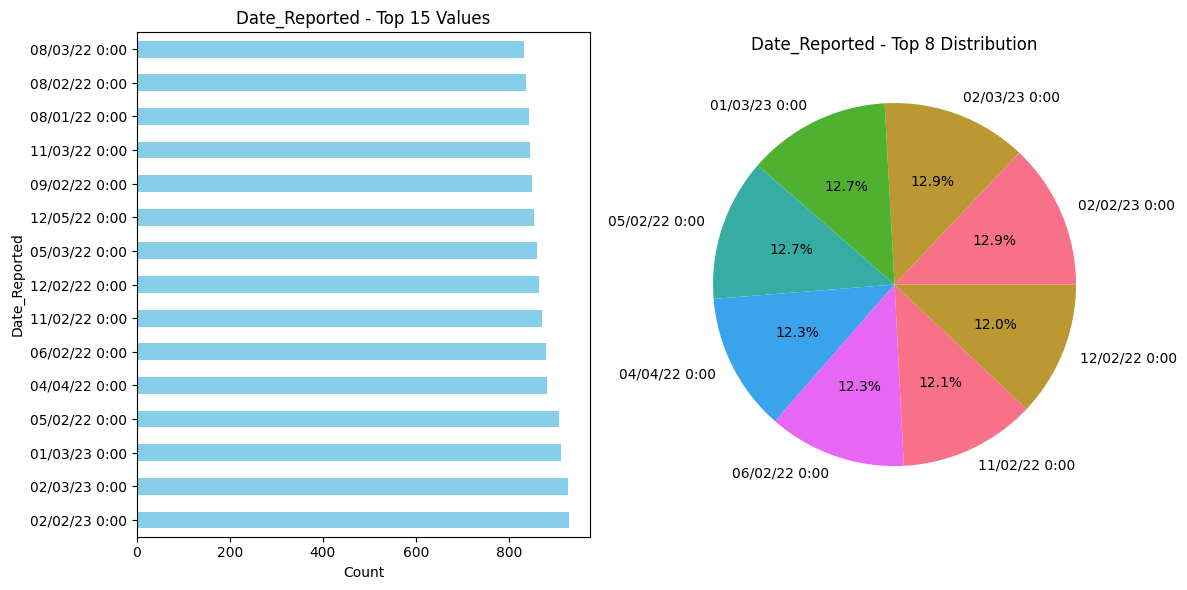


Date_Reported Stats:
  Unique values: 1708
  Most common: 02/02/23 0:00
  Missing values: 0


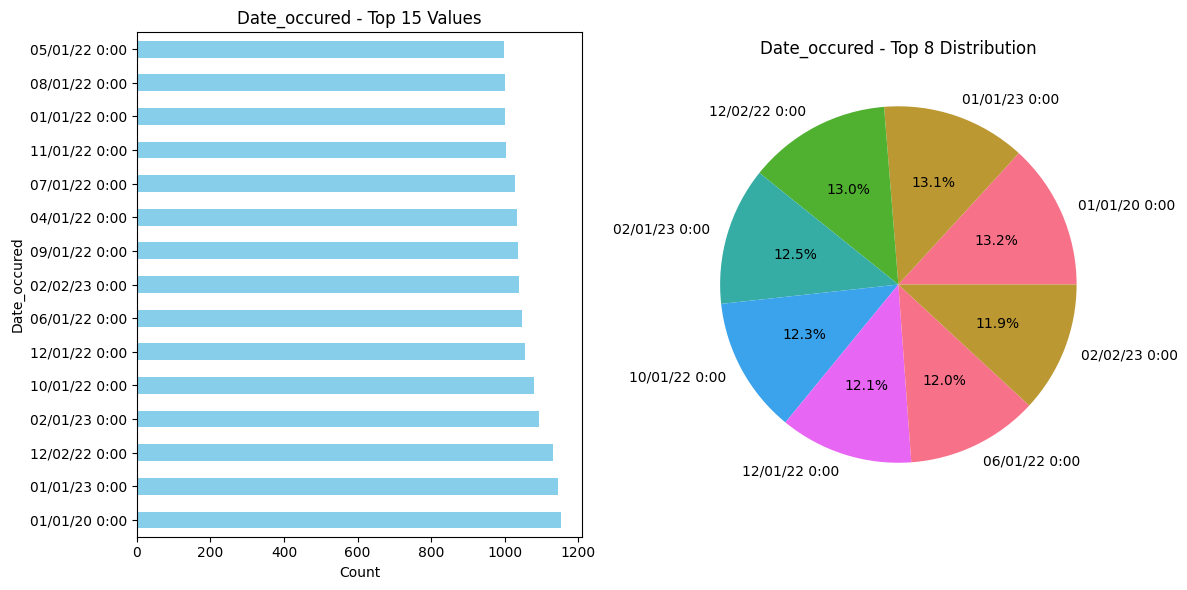


Date_occured Stats:
  Unique values: 1707
  Most common: 01/01/20 0:00
  Missing values: 0


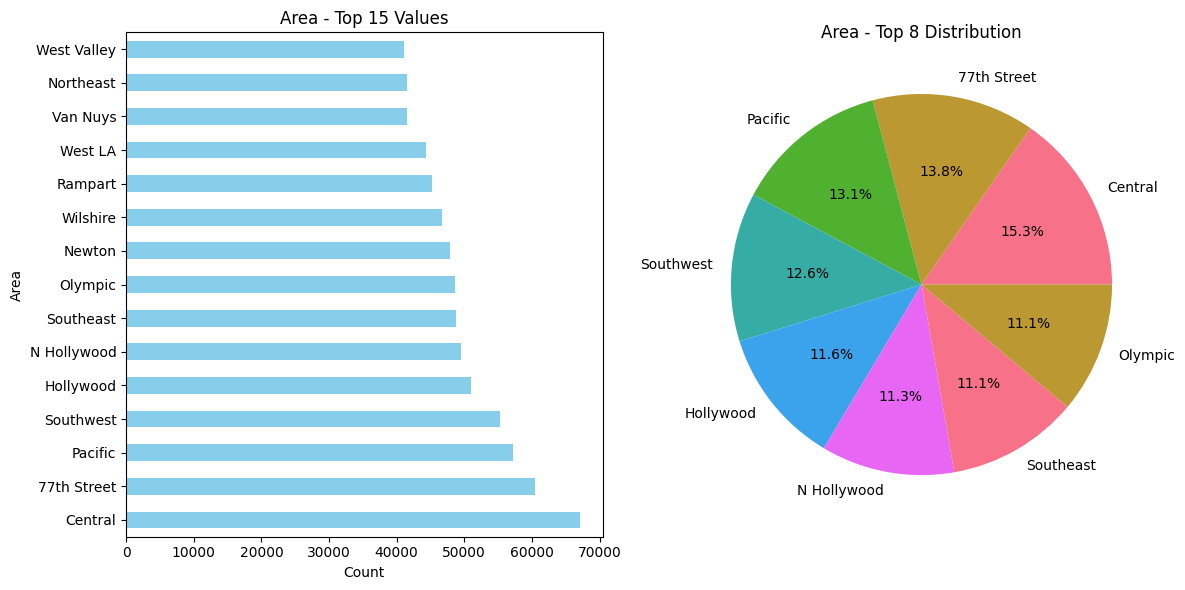


Area Stats:
  Unique values: 21
  Most common: Central
  Missing values: 0


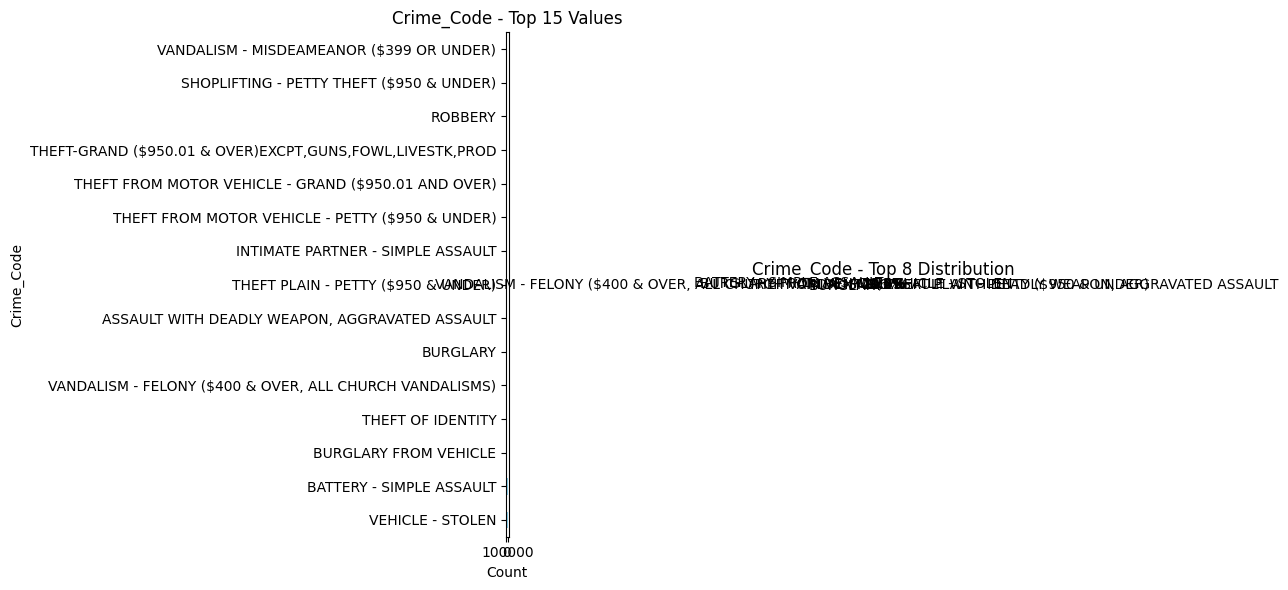


Crime_Code Stats:
  Unique values: 139
  Most common: VEHICLE - STOLEN
  Missing values: 0


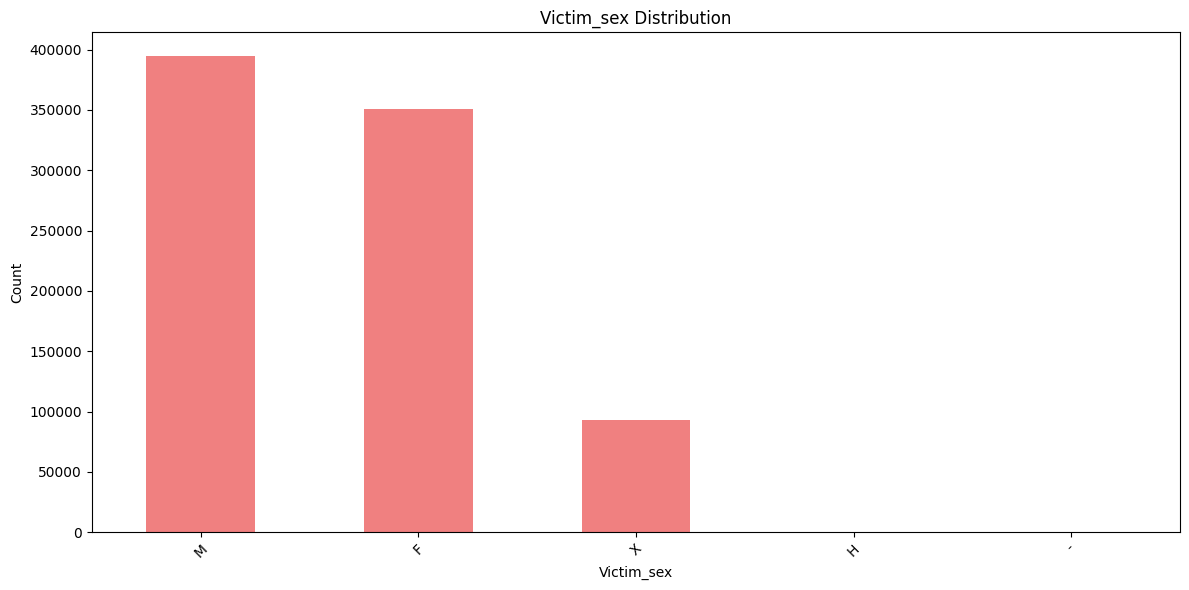


Victim_sex Stats:
  Unique values: 5
  Most common: M
  Missing values: 136003


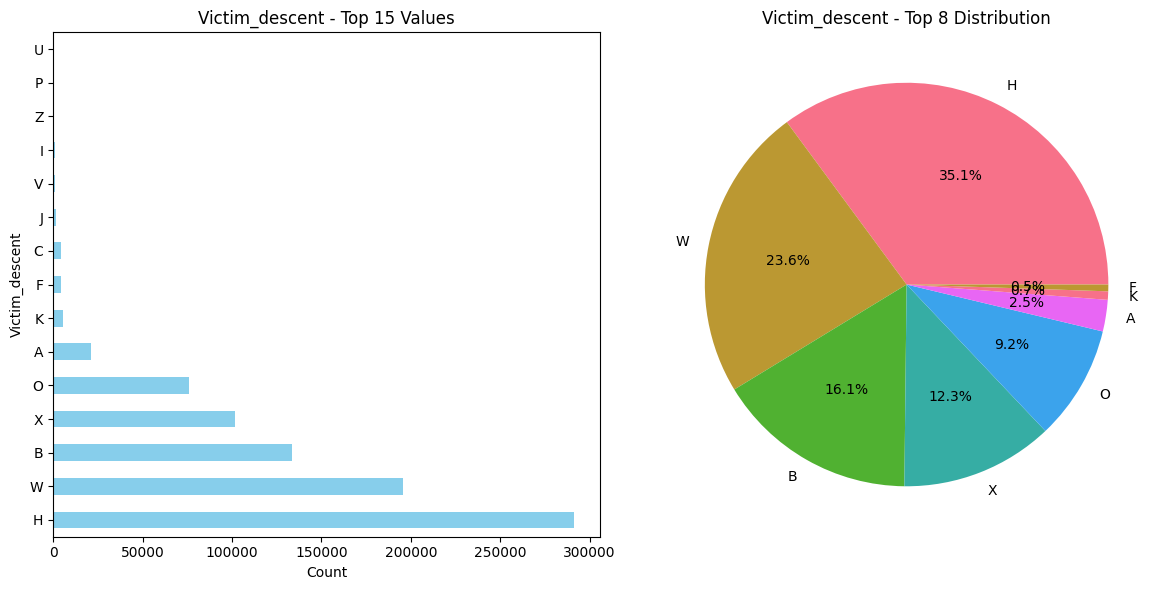


Victim_descent Stats:
  Unique values: 20
  Most common: H
  Missing values: 136013


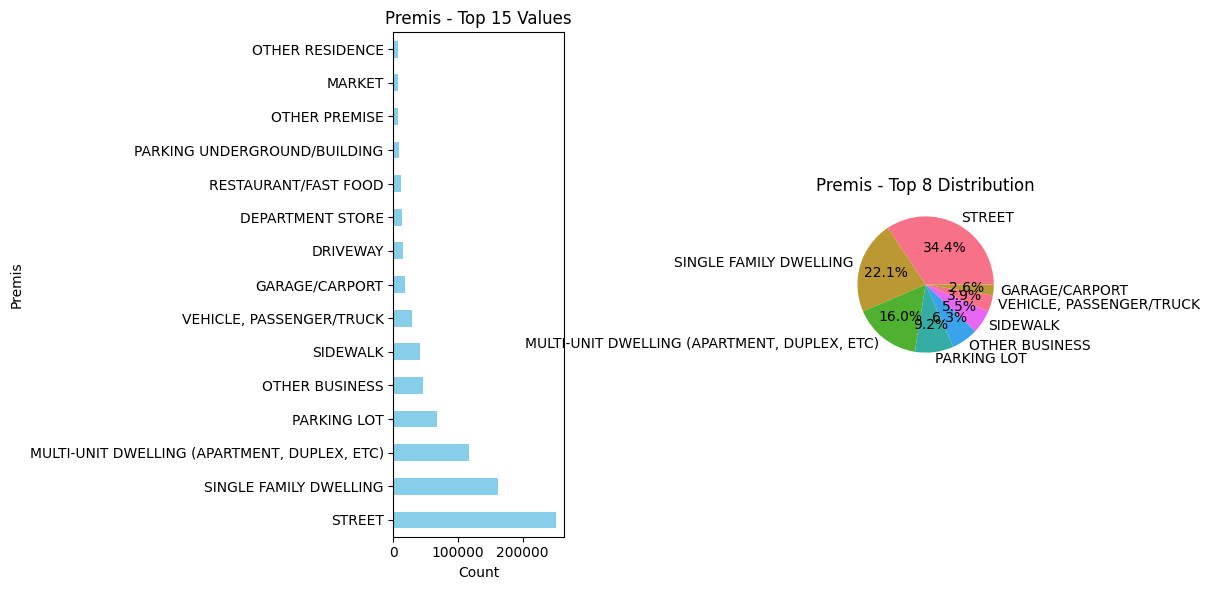


Premis Stats:
  Unique values: 306
  Most common: STREET
  Missing values: 584


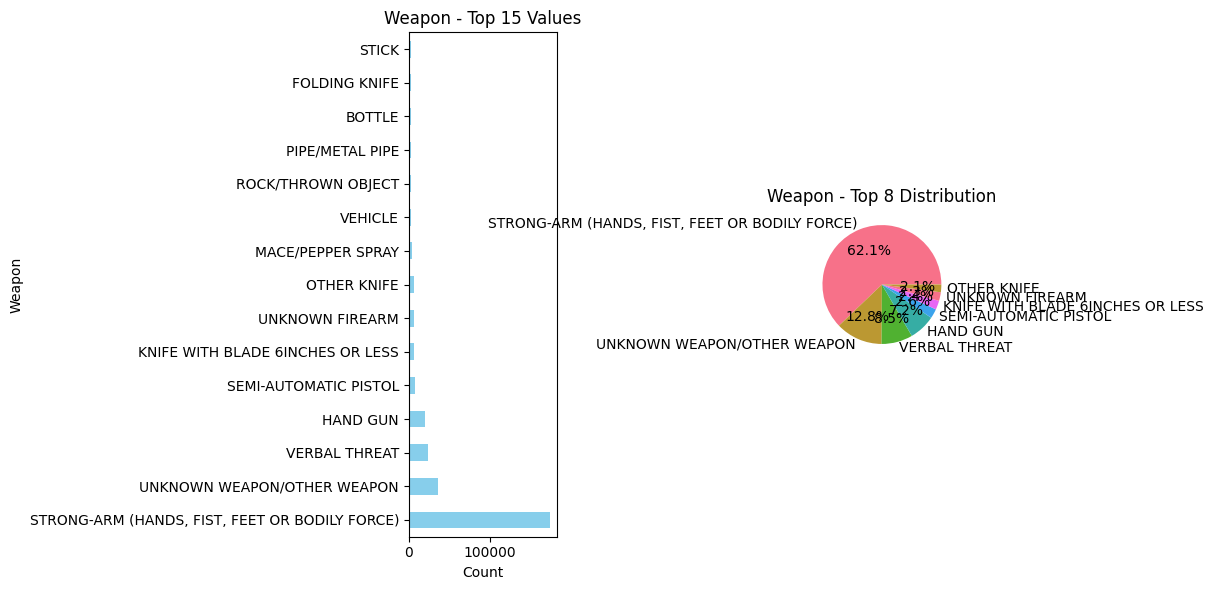


Weapon Stats:
  Unique values: 79
  Most common: STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)
  Missing values: 648695


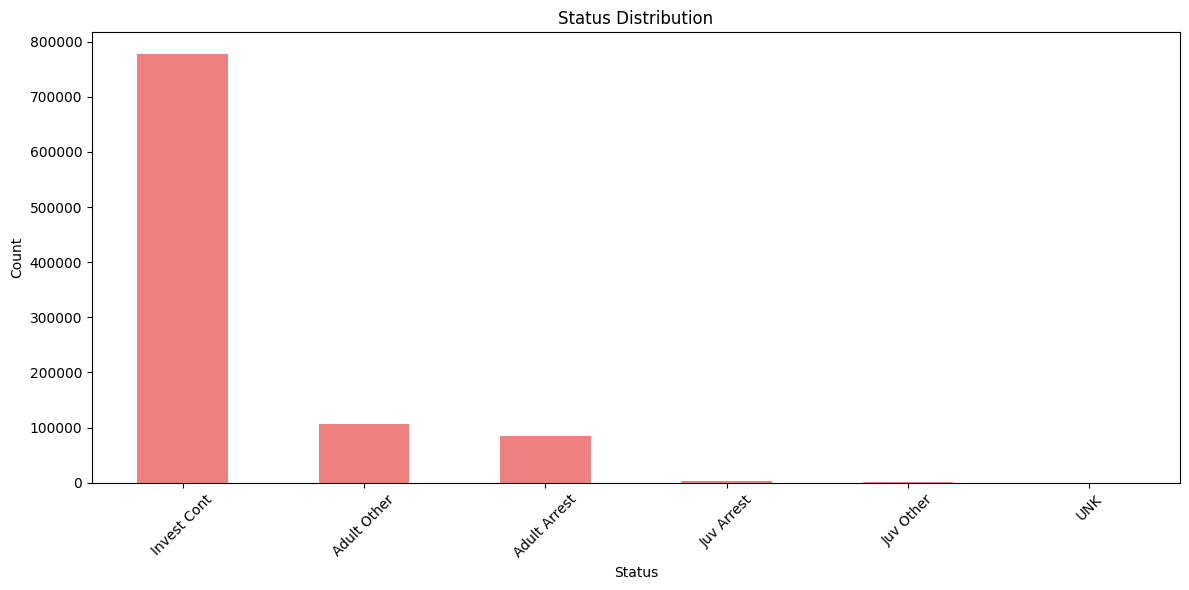


Status Stats:
  Unique values: 6
  Most common: Invest Cont
  Missing values: 0


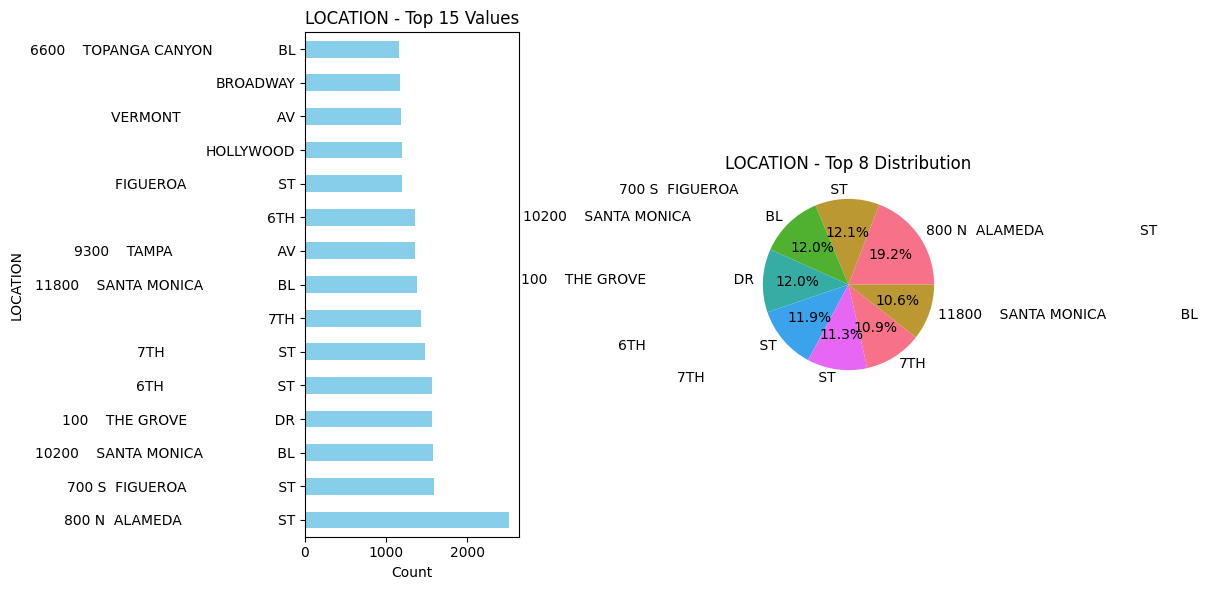


LOCATION Stats:
  Unique values: 66165
  Most common: 800 N  ALAMEDA                      ST
  Missing values: 0

2. NUMERICAL DISTRIBUTIONS:


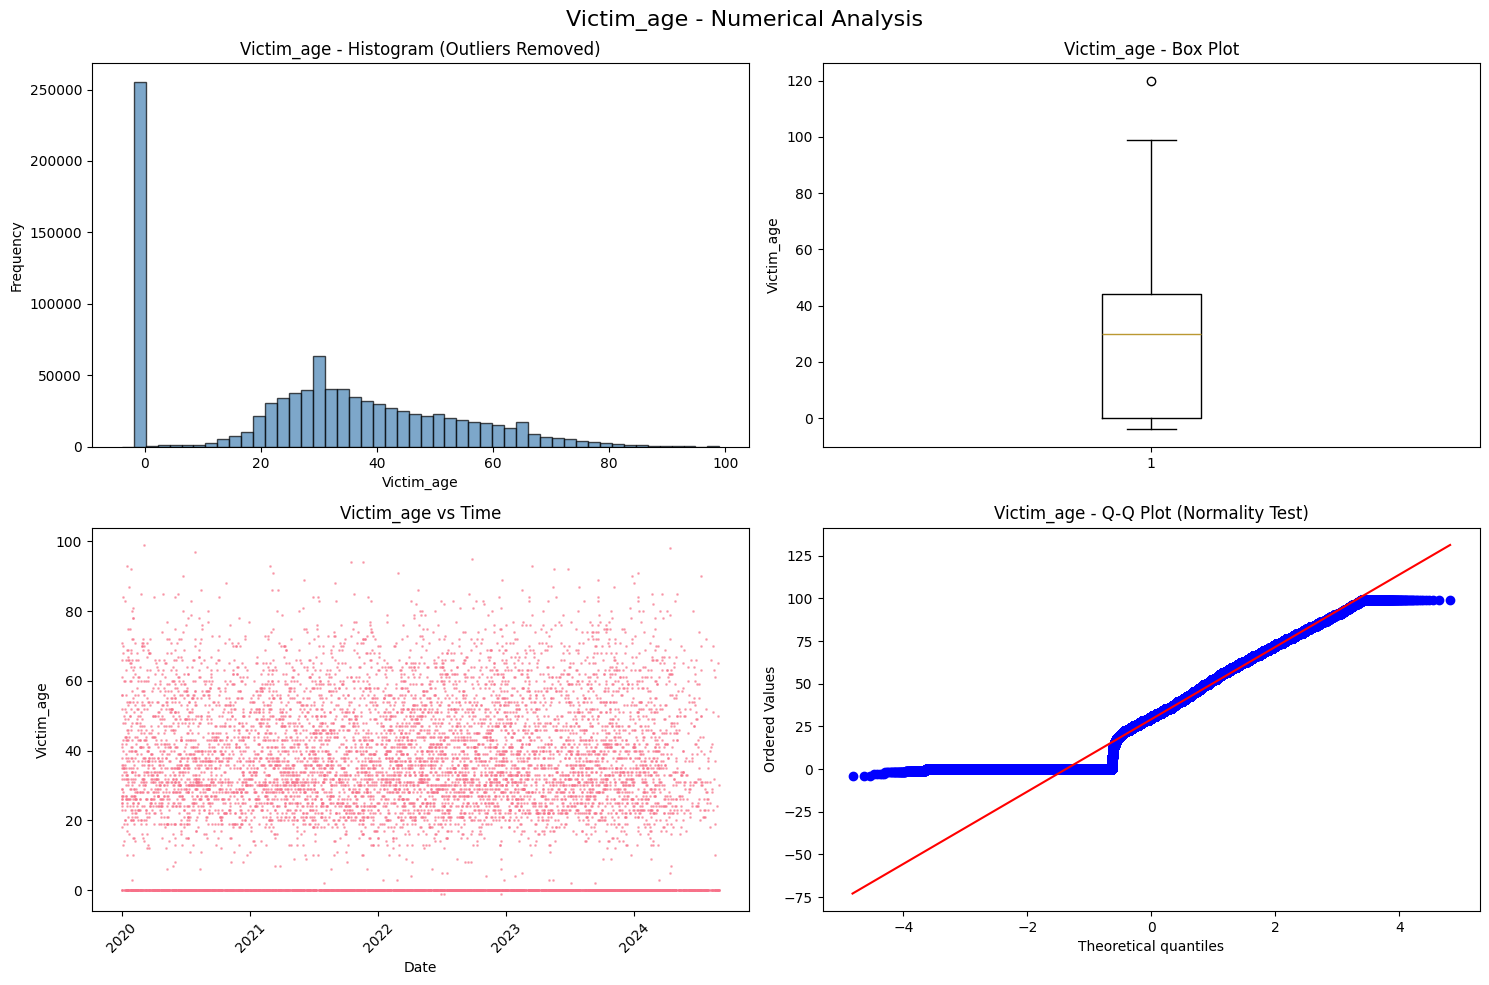


Victim_age Statistics:
  Count: 974477
  Mean: 29.17
  Median: 30.00
  Std: 21.95
  Min: -4
  Max: 120
  Missing: 0
  Outliers (IQR method): 1


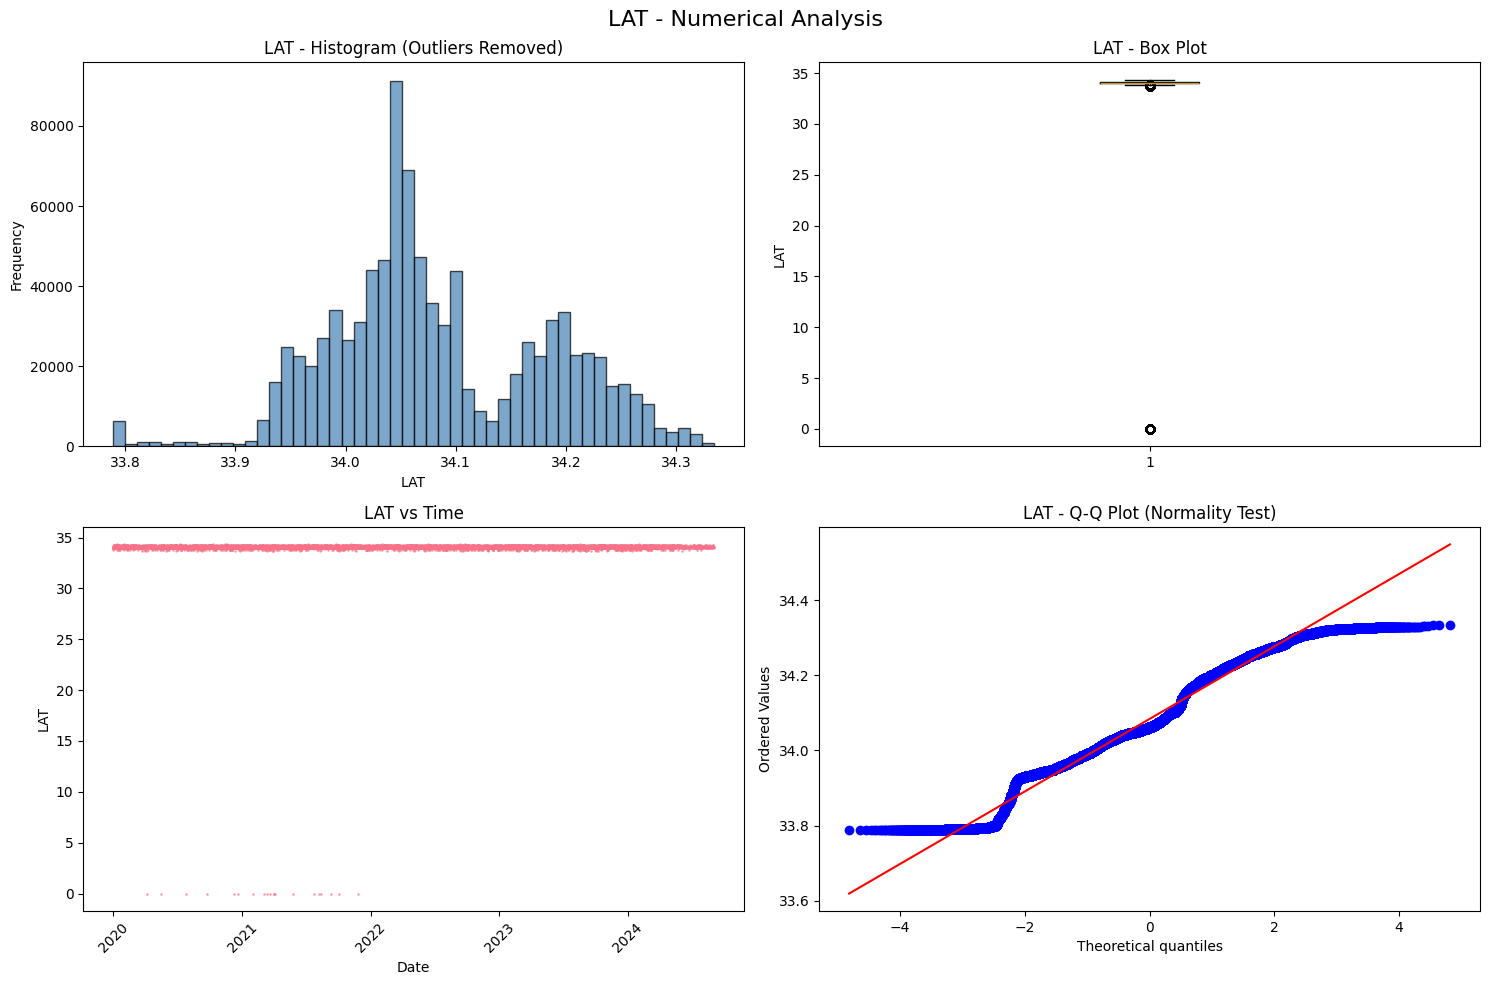


LAT Statistics:
  Count: 974477
  Mean: 34.00
  Median: 34.06
  Std: 1.64
  Min: 0.0
  Max: 34.3343
  Missing: 0
  Outliers (IQR method): 30048


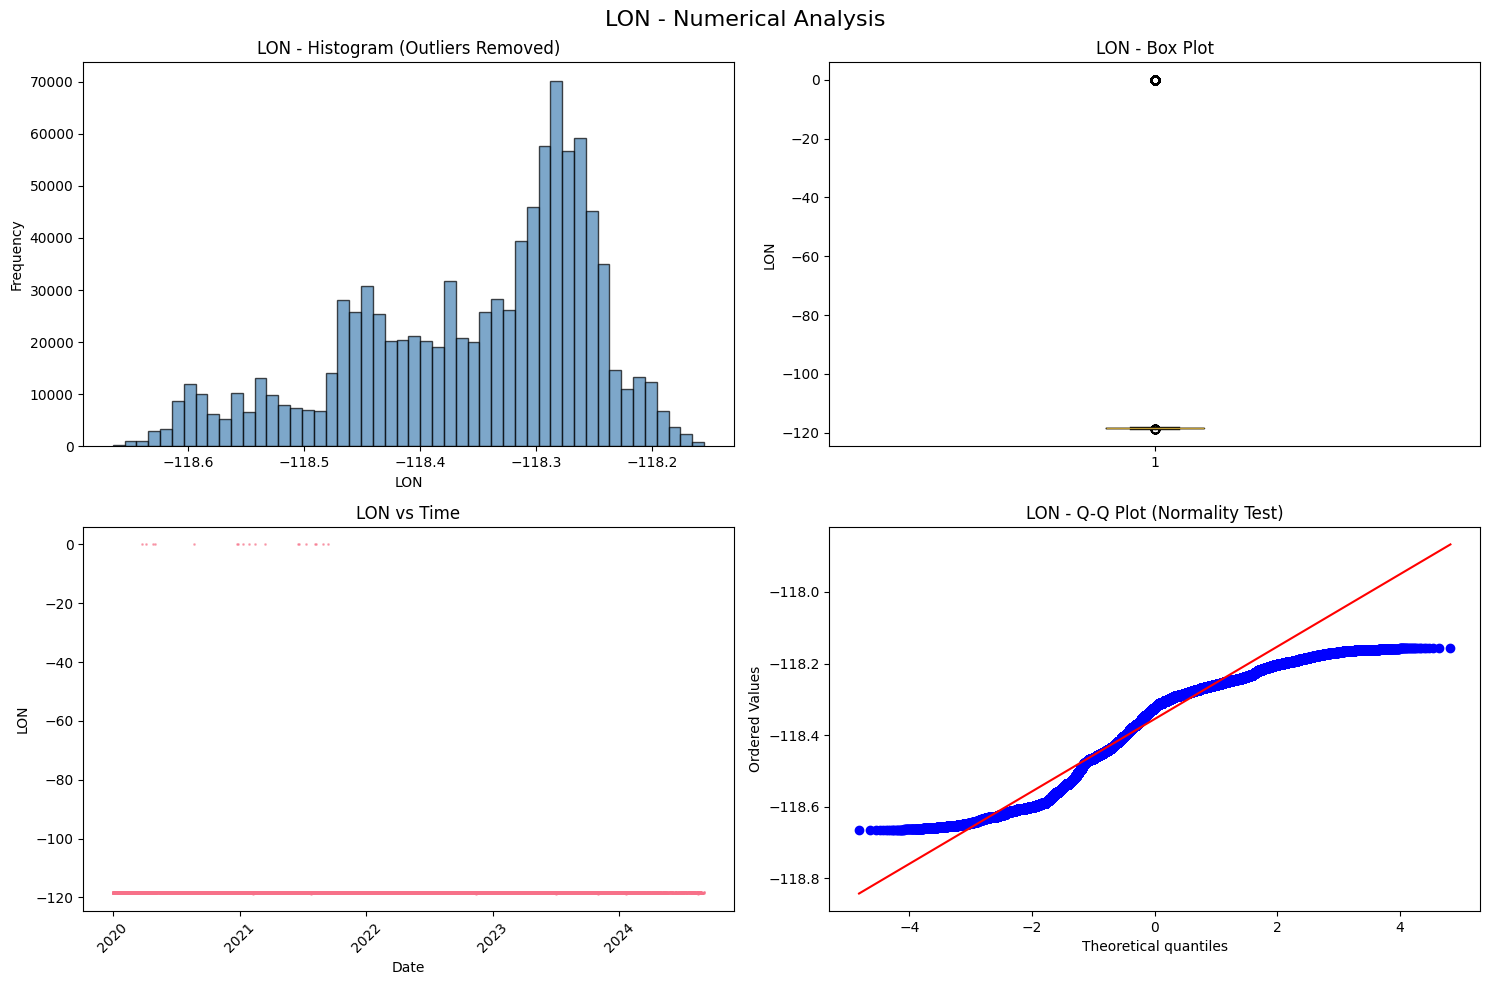


LON Statistics:
  Count: 974477
  Mean: -118.08
  Median: -118.32
  Std: 5.70
  Min: -118.6676
  Max: 0.0
  Missing: 0
  Outliers (IQR method): 2291


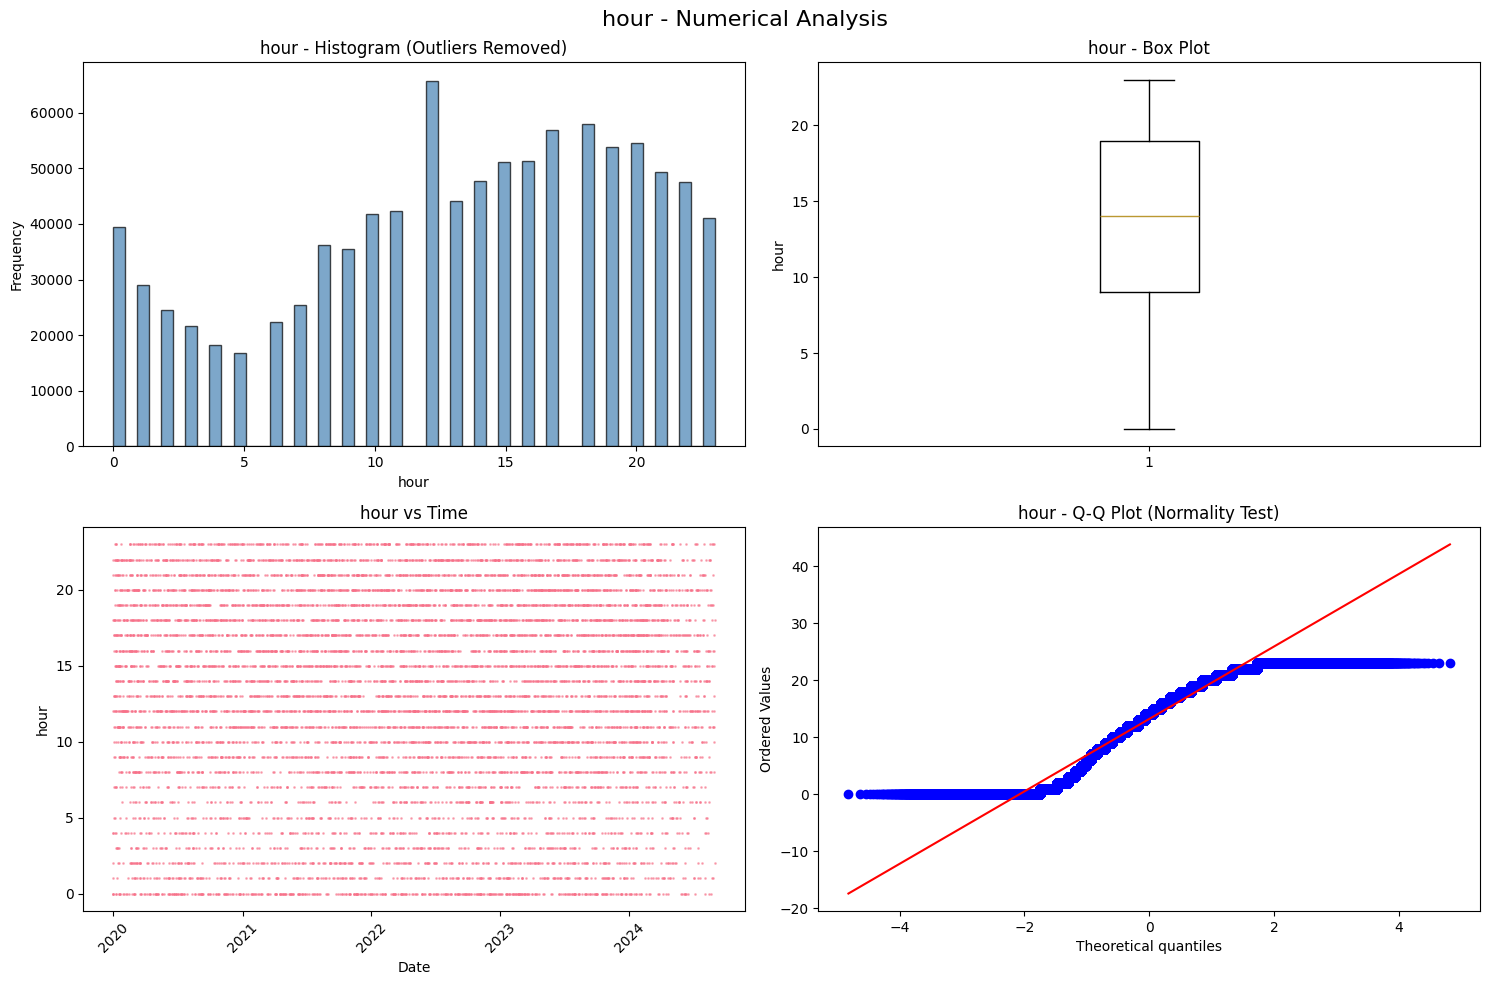


hour Statistics:
  Count: 974477
  Mean: 13.21
  Median: 14.00
  Std: 6.52
  Min: 0
  Max: 23
  Missing: 0
  Outliers (IQR method): 0


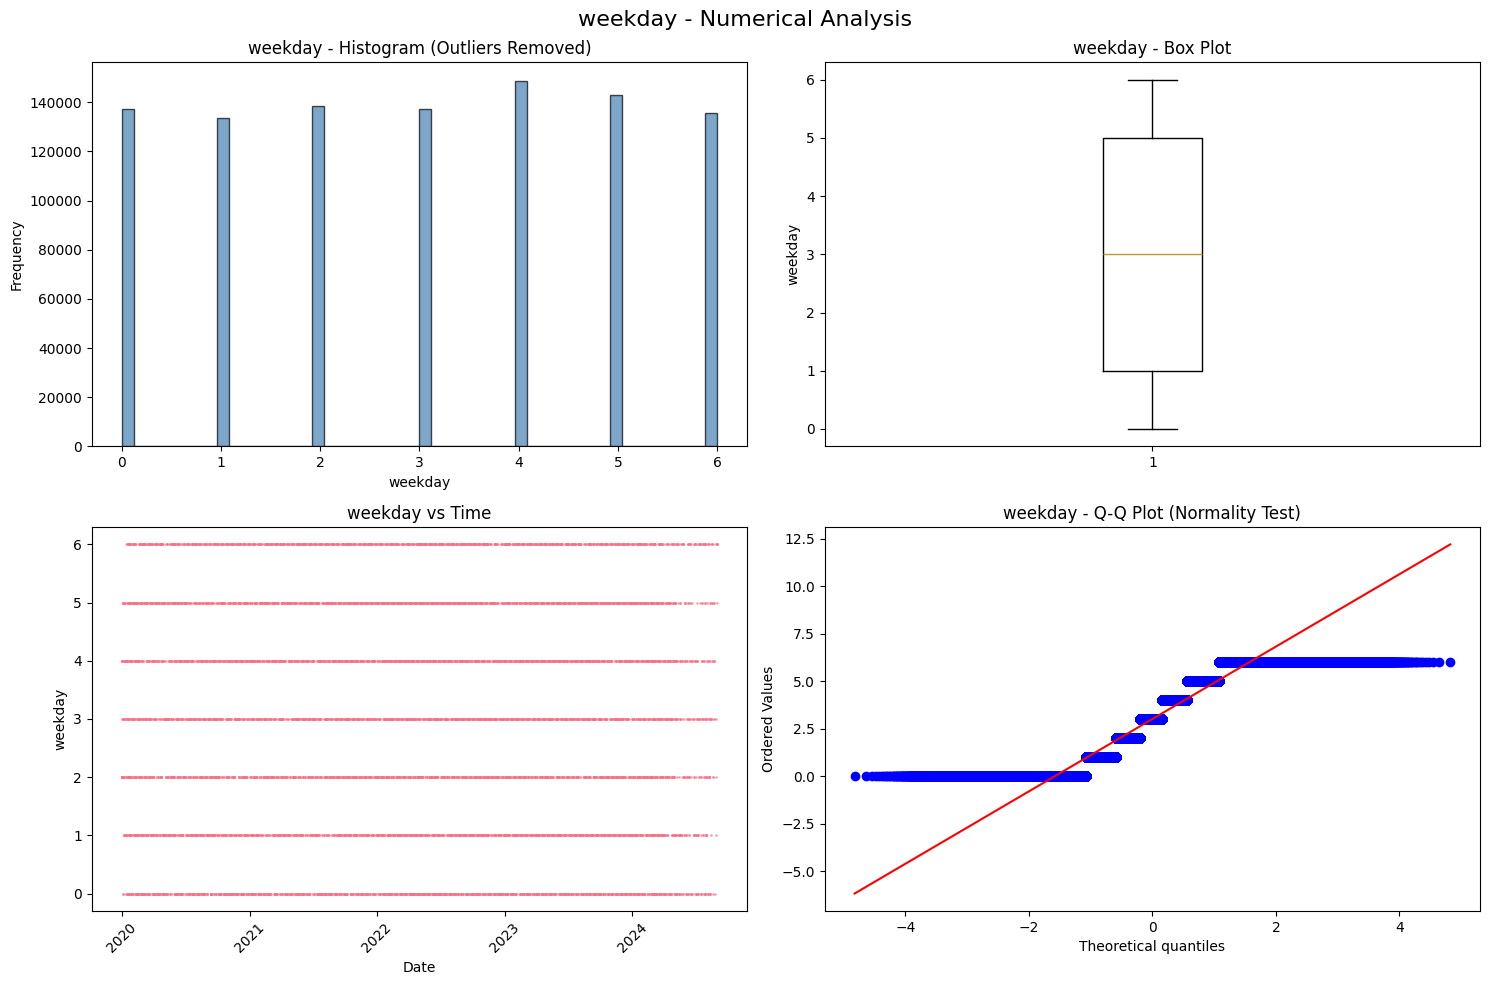


weekday Statistics:
  Count: 974477
  Mean: 3.02
  Median: 3.00
  Std: 1.99
  Min: 0
  Max: 6
  Missing: 0
  Outliers (IQR method): 0


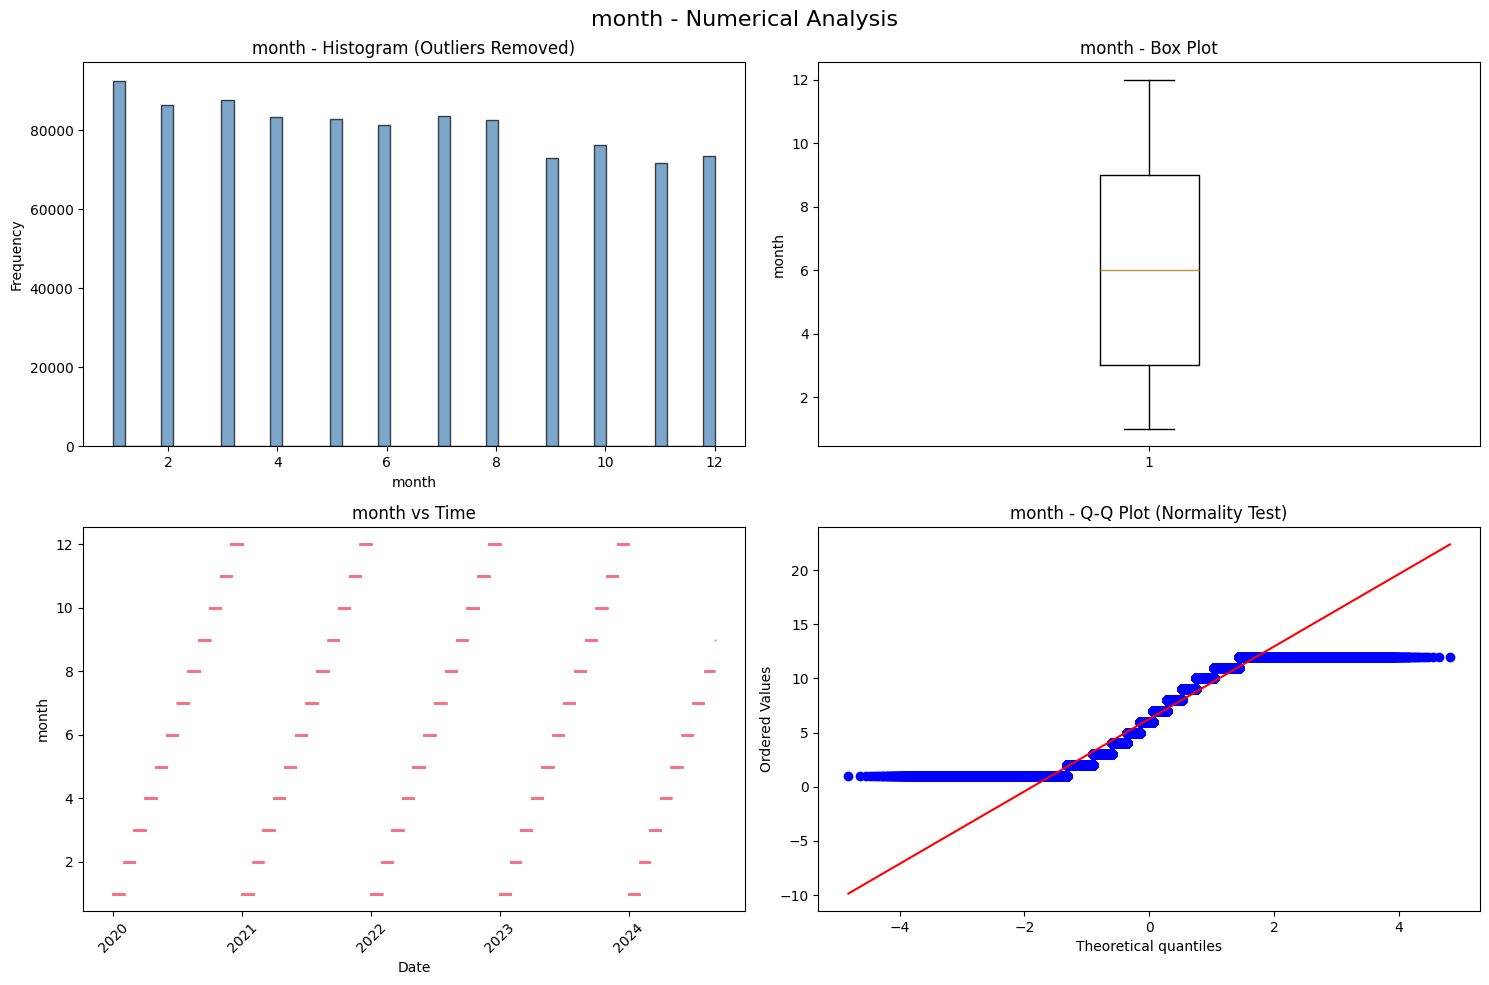


month Statistics:
  Count: 974477
  Mean: 6.26
  Median: 6.00
  Std: 3.44
  Min: 1
  Max: 12
  Missing: 0
  Outliers (IQR method): 0


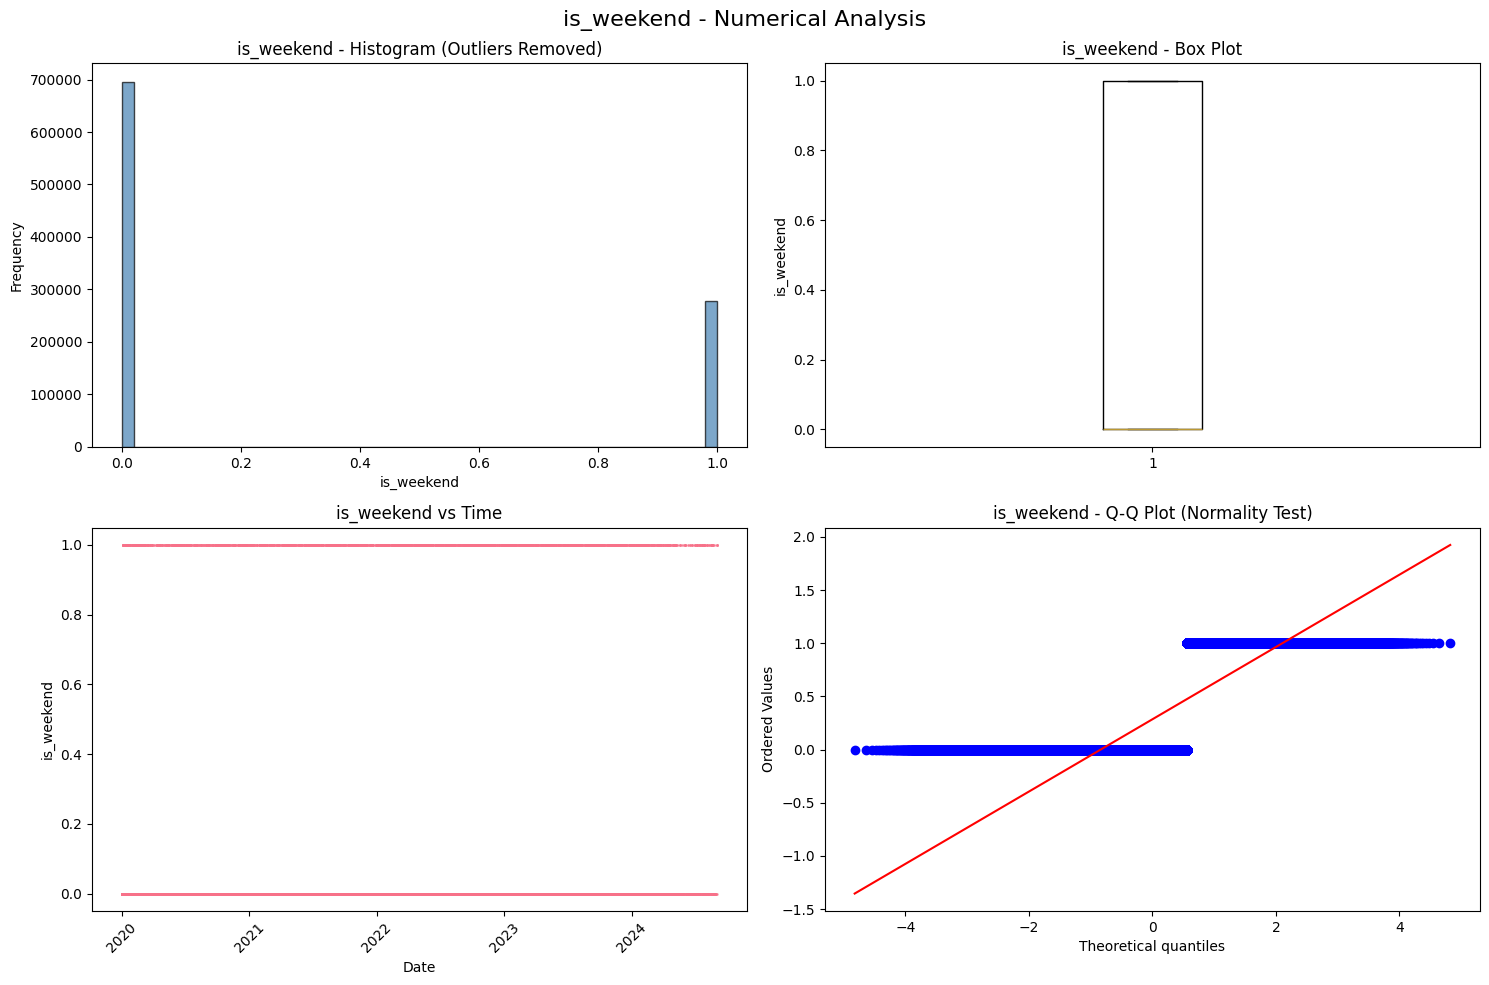


is_weekend Statistics:
  Count: 974477
  Mean: 0.29
  Median: 0.00
  Std: 0.45
  Min: 0
  Max: 1
  Missing: 0
  Outliers (IQR method): 0

3. CORRELATION ANALYSIS:


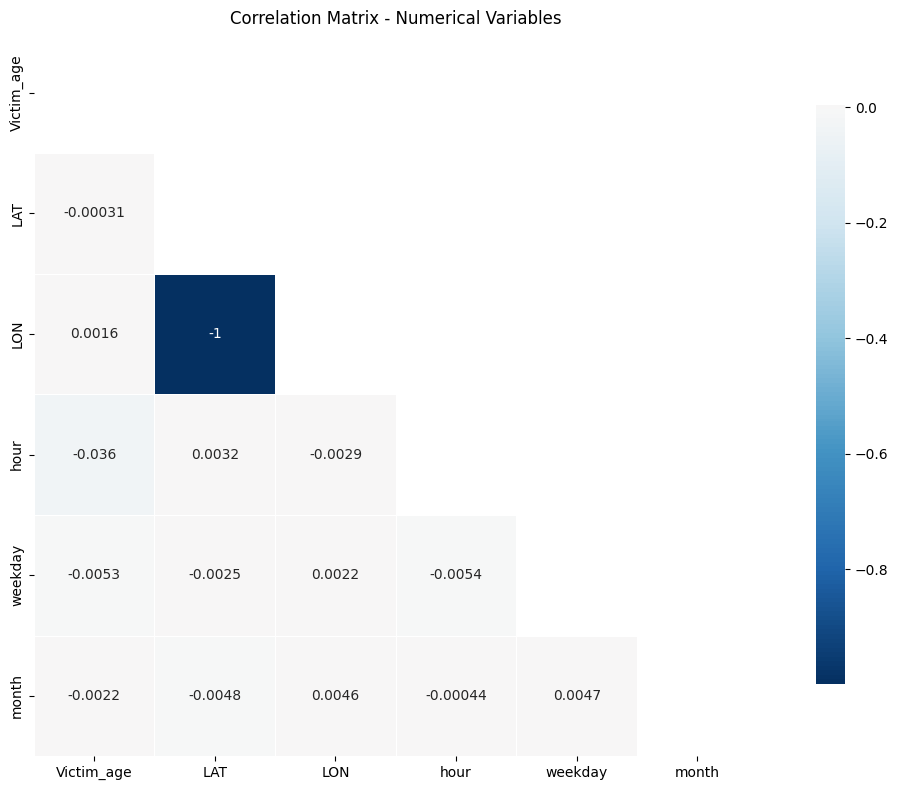


Strong Correlations (|r| > 0.5):
  LAT ↔ LON: -0.998

=== ANALYSIS COMPLETE ===
📊 All distribution plots generated!
📈 Check the correlation matrix for interesting relationships
📋 Review the printed statistics for data quality insights


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import ceil

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

print("=== DISTRIBUTION ANALYSIS ===\n")

# Identify categorical and numerical columns
categorical_cols = []
numerical_cols = []

for col in df.columns:
    if df[col].dtype in ['object', 'category']:
        categorical_cols.append(col)
    elif df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        # Skip ID-like columns or columns with too many unique values
        if col not in ['LAT', 'LON'] and df[col].nunique() < 50:
            numerical_cols.append(col)
        elif col in ['LAT', 'LON', 'Victim_age']:  # Special numerical columns
            numerical_cols.append(col)

print(f"Found {len(categorical_cols)} categorical columns: {categorical_cols}")
print(f"Found {len(numerical_cols)} numerical columns: {numerical_cols}")

# ====== CATEGORICAL DISTRIBUTIONS (Histograms/Bar Charts) ======
print("\n1. CATEGORICAL DISTRIBUTIONS:")

# Function to create categorical plots
def plot_categorical_distribution(col, max_categories=15):
    plt.figure(figsize=(12, 6))

    # Get value counts
    value_counts = df[col].value_counts().head(max_categories)

    if len(value_counts) > 10:
        # Horizontal bar chart for many categories
        plt.subplot(1, 2, 1)
        value_counts.plot(kind='barh', color='skyblue')
        plt.title(f'{col} - Top {max_categories} Values')
        plt.xlabel('Count')

        # Pie chart for top categories
        plt.subplot(1, 2, 2)
        value_counts.head(8).plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'{col} - Top 8 Distribution')
        plt.ylabel('')
    else:
        # Regular bar chart for fewer categories
        value_counts.plot(kind='bar', color='lightcoral', rot=45)
        plt.title(f'{col} Distribution')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Print stats
    print(f"\n{col} Stats:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Most common: {df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'}")
    print(f"  Missing values: {df[col].isnull().sum()}")

# Plot categorical distributions
for col in categorical_cols:
    if df[col].nunique() > 1:  # Skip columns with only one value
        plot_categorical_distribution(col)

# ====== NUMERICAL DISTRIBUTIONS (Histograms + Scatter Plots) ======
print("\n2. NUMERICAL DISTRIBUTIONS:")

def plot_numerical_distribution(col):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{col} - Numerical Analysis', fontsize=16)

    # Remove outliers for better visualization
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = df[col][(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # 1. Histogram
    axes[0, 0].hist(filtered_data.dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 0].set_title(f'{col} - Histogram (Outliers Removed)')
    axes[0, 0].set_xlabel(col)
    axes[0, 0].set_ylabel('Frequency')

    # 2. Box plot
    axes[0, 1].boxplot(df[col].dropna(), vert=True)
    axes[0, 1].set_title(f'{col} - Box Plot')
    axes[0, 1].set_ylabel(col)

    # 3. Scatter plot vs date (if date column exists)
    if 'date' in df.columns:
        sample_data = df.sample(min(10000, len(df)))  # Sample for performance
        axes[1, 0].scatter(sample_data['date'], sample_data[col], alpha=0.5, s=1)
        axes[1, 0].set_title(f'{col} vs Time')
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].set_ylabel(col)
        axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Q-Q plot for normality check
    from scipy import stats
    stats.probplot(filtered_data.dropna(), dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title(f'{col} - Q-Q Plot (Normality Test)')

    plt.tight_layout()
    plt.show()

    # Print detailed stats
    print(f"\n{col} Statistics:")
    print(f"  Count: {df[col].count()}")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median():.2f}")
    print(f"  Std: {df[col].std():.2f}")
    print(f"  Min: {df[col].min()}")
    print(f"  Max: {df[col].max()}")
    print(f"  Missing: {df[col].isnull().sum()}")
    print(f"  Outliers (IQR method): {((df[col] < lower_bound) | (df[col] > upper_bound)).sum()}")

# Plot numerical distributions
for col in numerical_cols:
    if df[col].nunique() > 1 and df[col].notna().sum() > 0:
        plot_numerical_distribution(col)

# ====== CORRELATION MATRIX FOR NUMERICAL COLUMNS ======
print("\n3. CORRELATION ANALYSIS:")

# Select numerical columns with sufficient data
corr_cols = [col for col in numerical_cols if df[col].notna().sum() > 100 and df[col].nunique() > 2]

if len(corr_cols) > 1:
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[corr_cols].corr()

    # Create correlation heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix - Numerical Variables')
    plt.tight_layout()
    plt.show()

    # Print strong correlations
    print("\nStrong Correlations (|r| > 0.5):")
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                col1, col2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
                print(f"  {col1} ↔ {col2}: {corr_val:.3f}")

print("\n=== ANALYSIS COMPLETE ===")
print("📊 All distribution plots generated!")
print("📈 Check the correlation matrix for interesting relationships")
print("📋 Review the printed statistics for data quality insights")

In [18]:
# A slimmer working set can help (drop raw text cols you don’t need right now)
keep_cols = [
    "dr_no","dt_occ","date","hour","weekday","month","weekofyear","dayofyear","quarter","season",
    "is_weekend","is_holiday","area_name","crime_code","crime_desc","premise_desc","weapon_desc",
    "victim_age","victim_sex","victim_descent","lat","lon","h3",
    "cnt","roll_7d","roll_28d","neighbor_mean","burstiness",
    "outlier_z","outlier_iqr","outlier_dbscan_spatial","outlier_any"
]
keep_cols = [c for c in keep_cols if c in df.columns]
df_final = df[keep_cols].copy()

clean_path = "/content/lapd_features.parquet"
log_path   = "/content/data_issues_log.csv"

df_final.to_parquet(clean_path, index=False)
issues_log.to_csv(log_path, index=False)

print(f"Saved feature table → {clean_path}")
print(f"Saved issues log   → {log_path}")
df_final.head(2)


Saved feature table → /content/lapd_features.parquet
Saved issues log   → /content/data_issues_log.csv


,dt_occ,date,hour,weekday,month,weekofyear,dayofyear,quarter,season,is_weekend,is_holiday,outlier_z,outlier_iqr,outlier_dbscan_spatial,outlier_any
0,NaT,2020-03-01,21,6,3,<NA>,NaN,NaN,NaN,1,0,0,0,0,0
1,NaT,2020-02-08,18,5,2,<NA>,NaN,NaN,NaN,1,0,0,0,0,0


=== DISTRIBUTION ANALYSIS (SCALED DATA) ===


1. NUMERICAL DISTRIBUTIONS (SCALED):


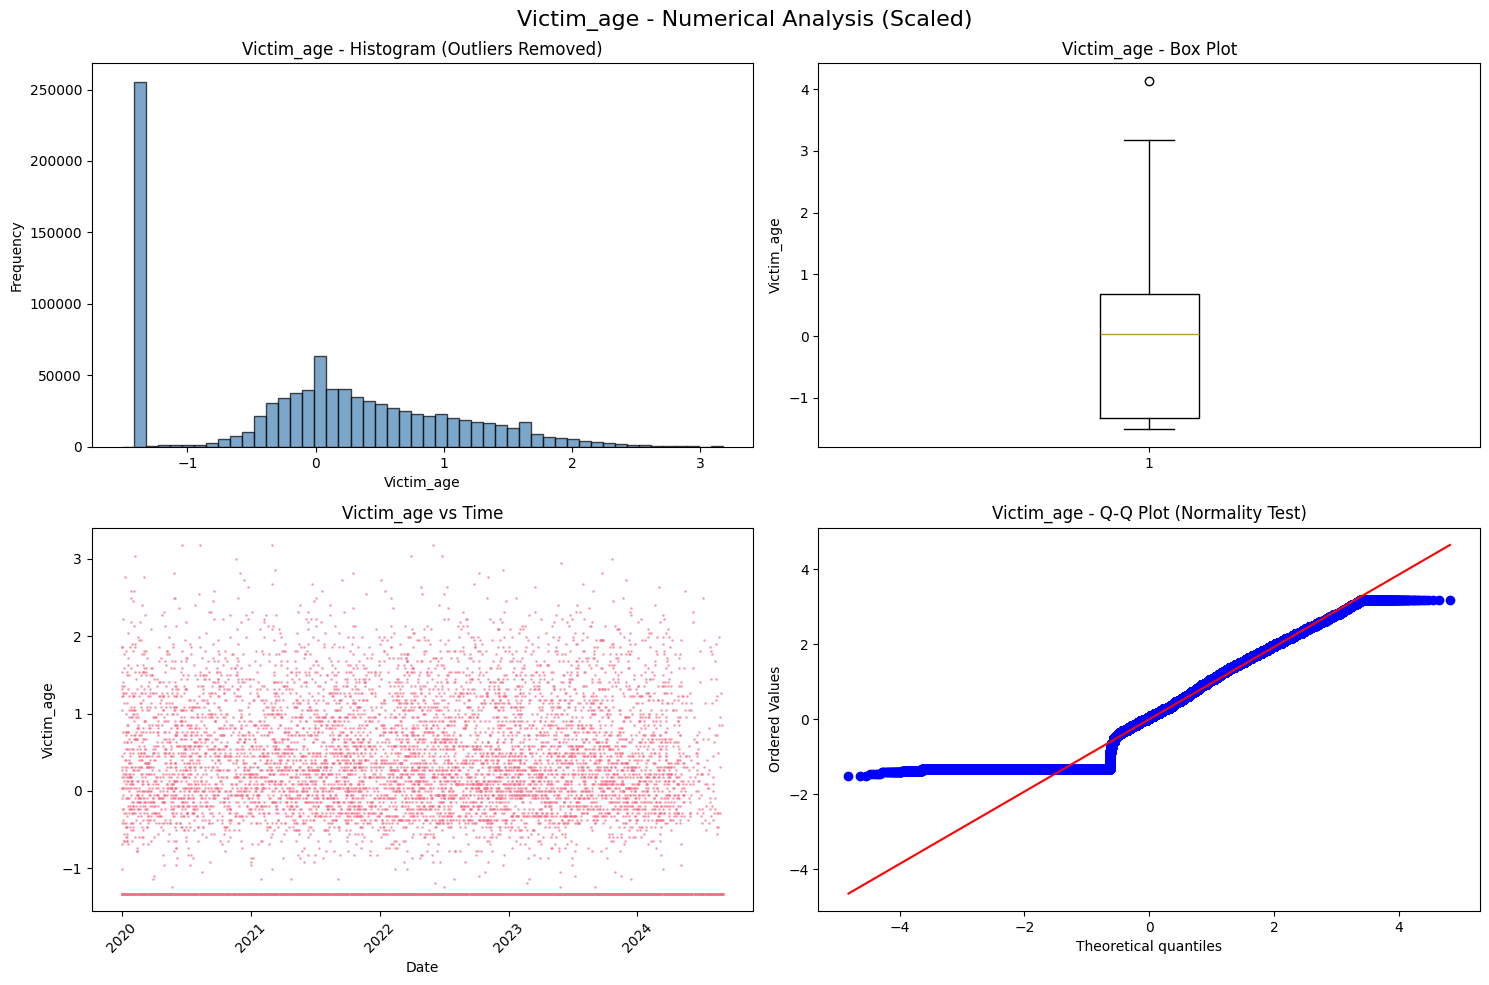


Victim_age Statistics (Scaled):
  Count: 974477
  Mean: -0.00
  Median: 0.04
  Std: 1.00
  Min: -1.51
  Max: 4.14
  Missing: 0
  Outliers (IQR method): 1


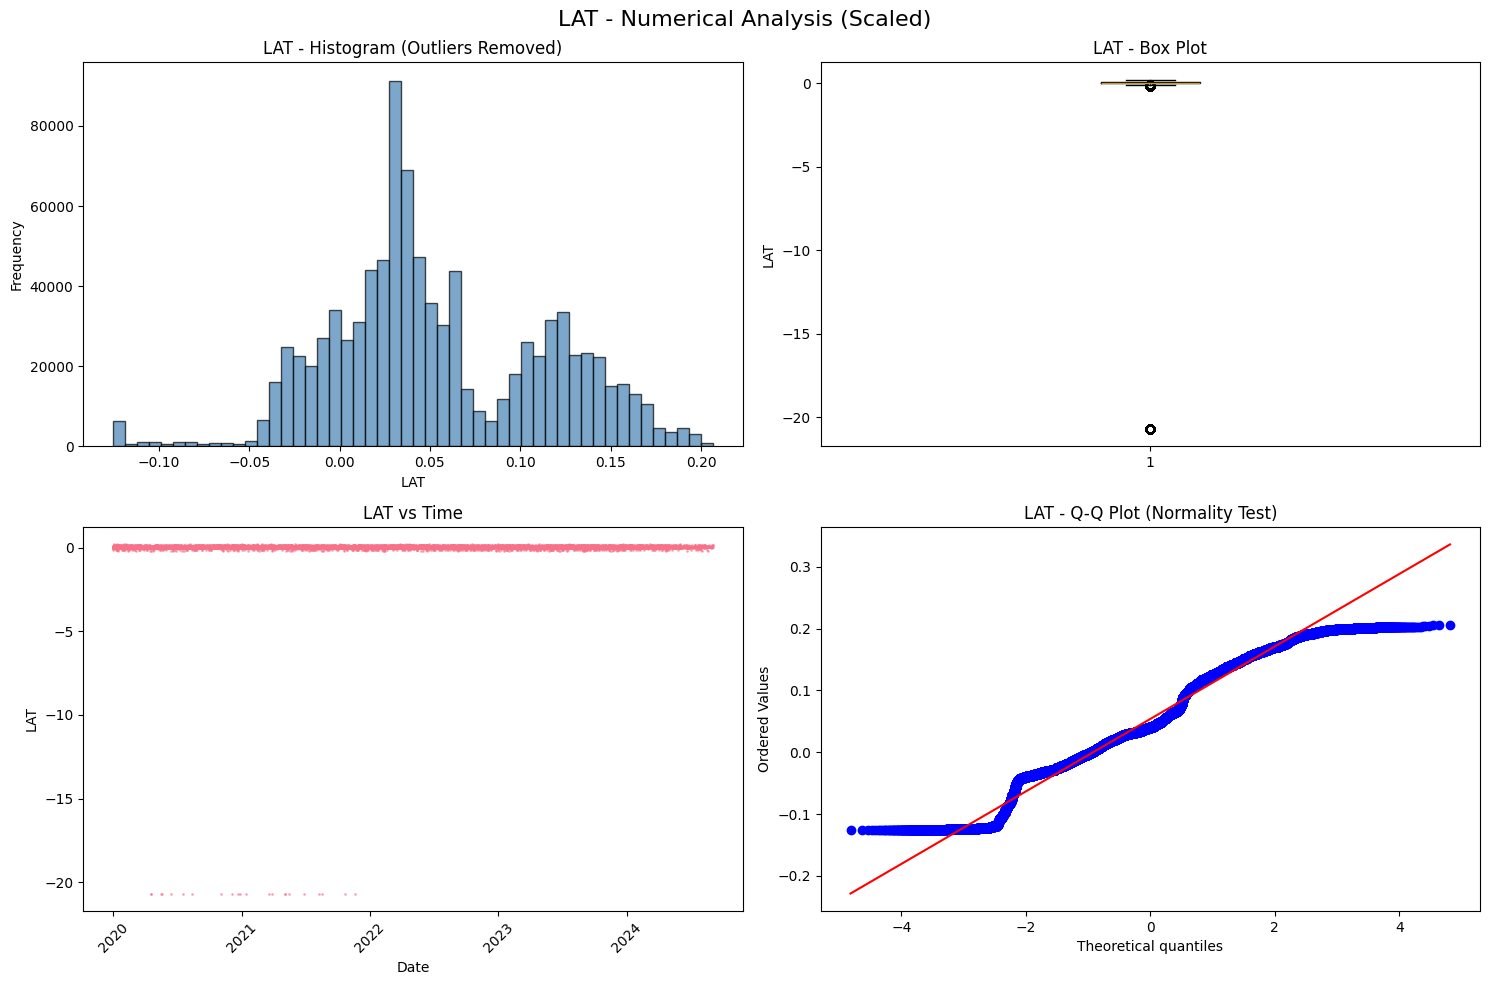


LAT Statistics (Scaled):
  Count: 974477
  Mean: -0.00
  Median: 0.04
  Std: 1.00
  Min: -20.68
  Max: 0.21
  Missing: 0
  Outliers (IQR method): 30048


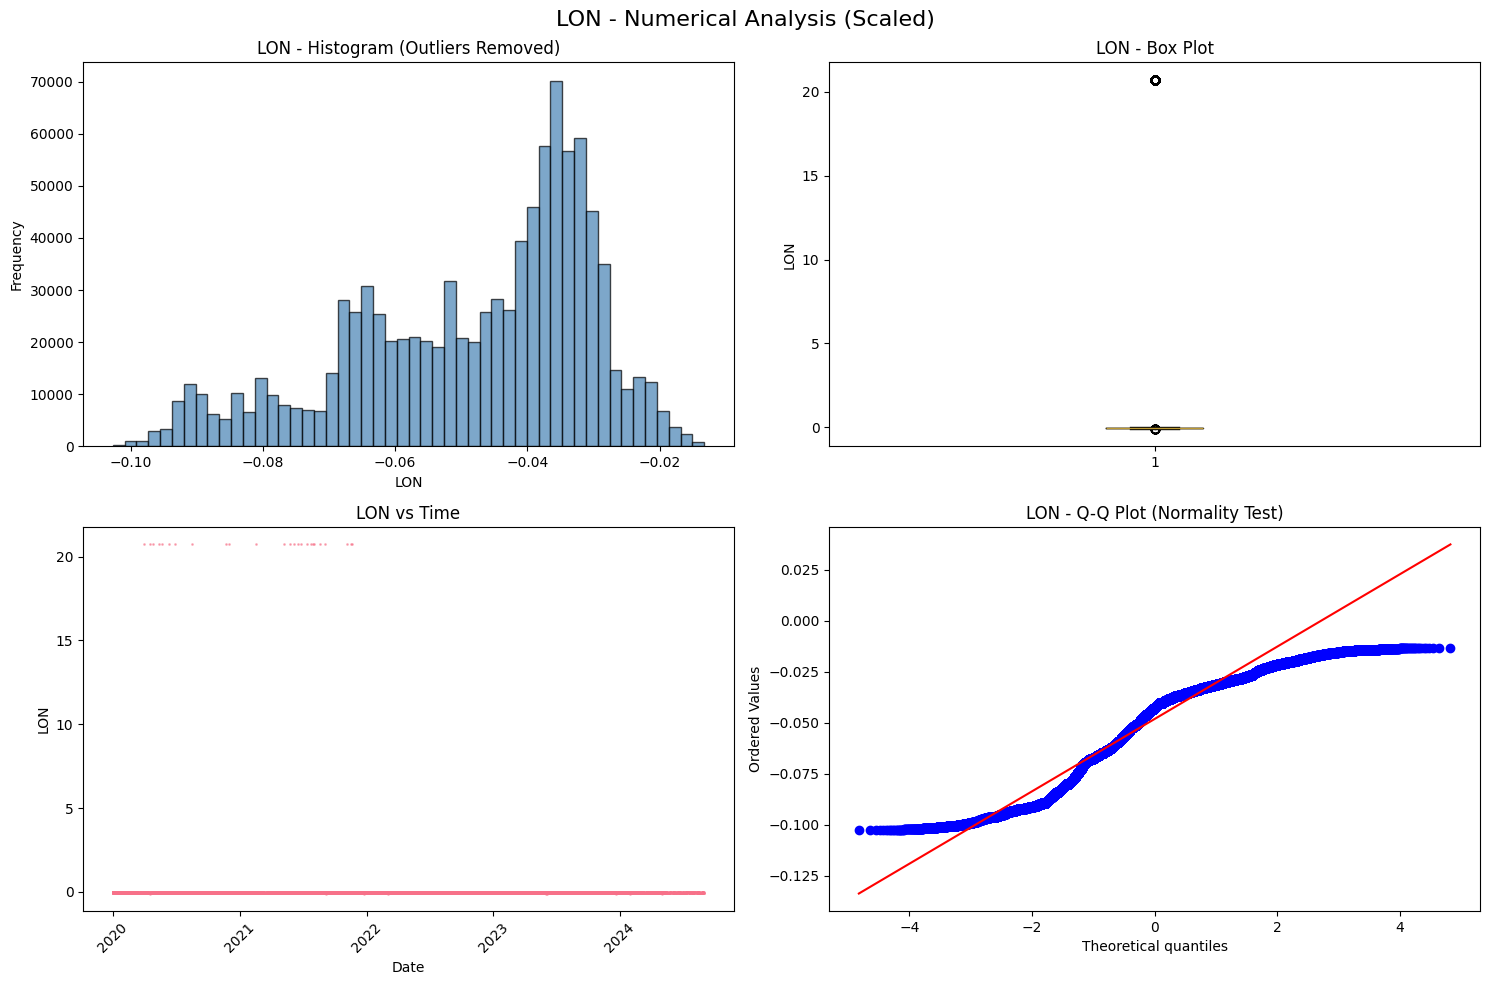


LON Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.04
  Std: 1.00
  Min: -0.10
  Max: 20.73
  Missing: 0
  Outliers (IQR method): 2291


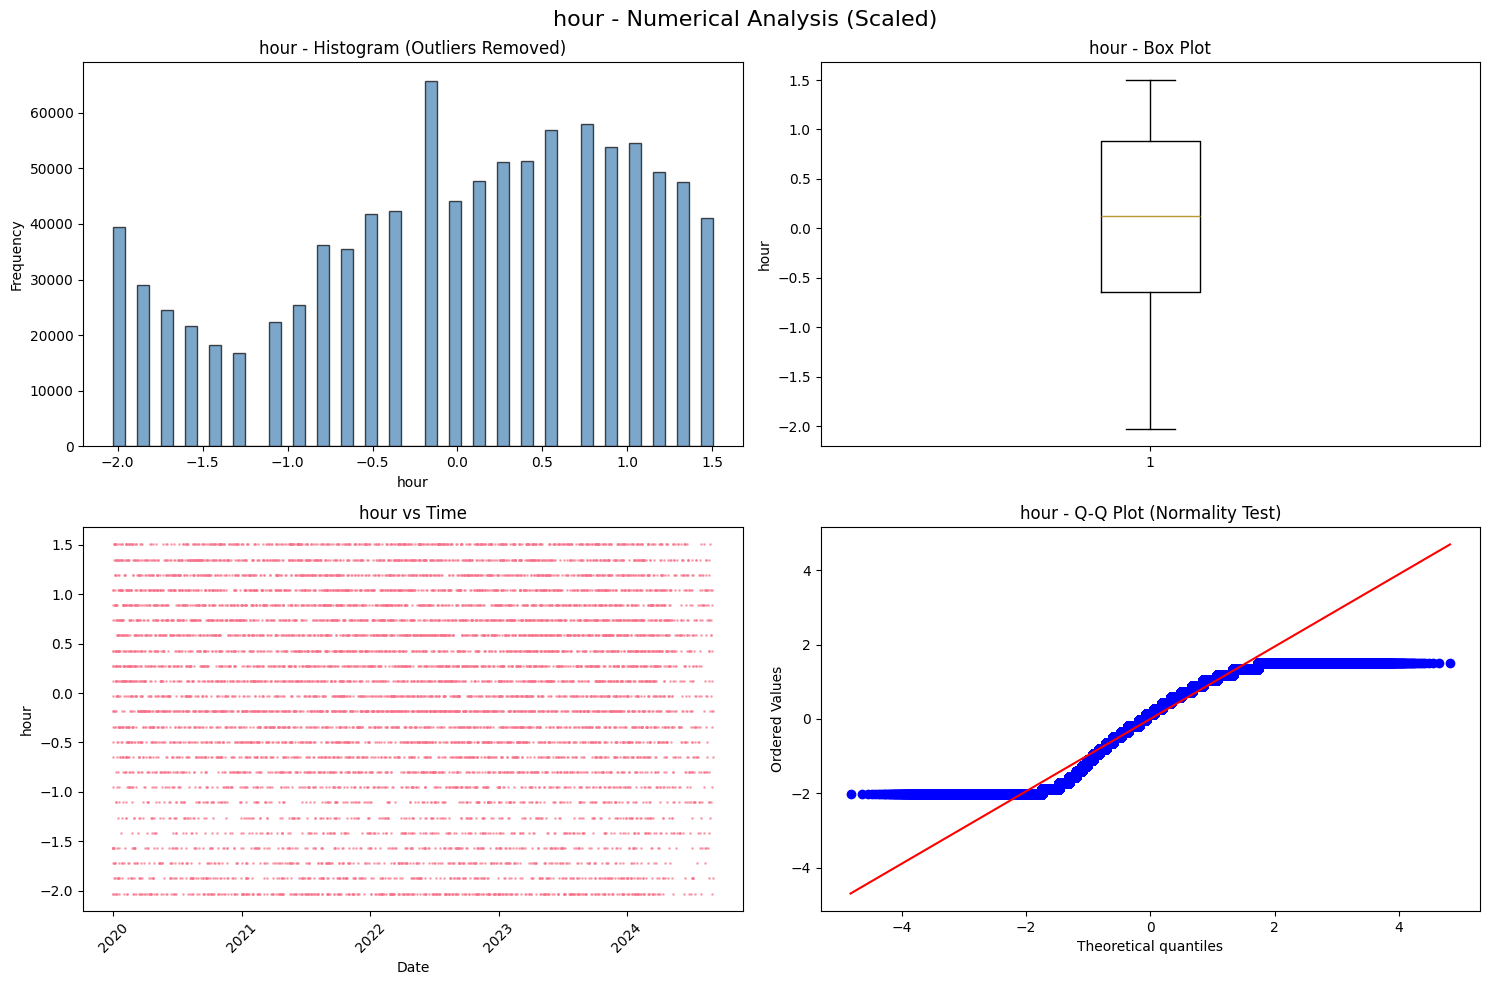


hour Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: 0.12
  Std: 1.00
  Min: -2.03
  Max: 1.50
  Missing: 0
  Outliers (IQR method): 0


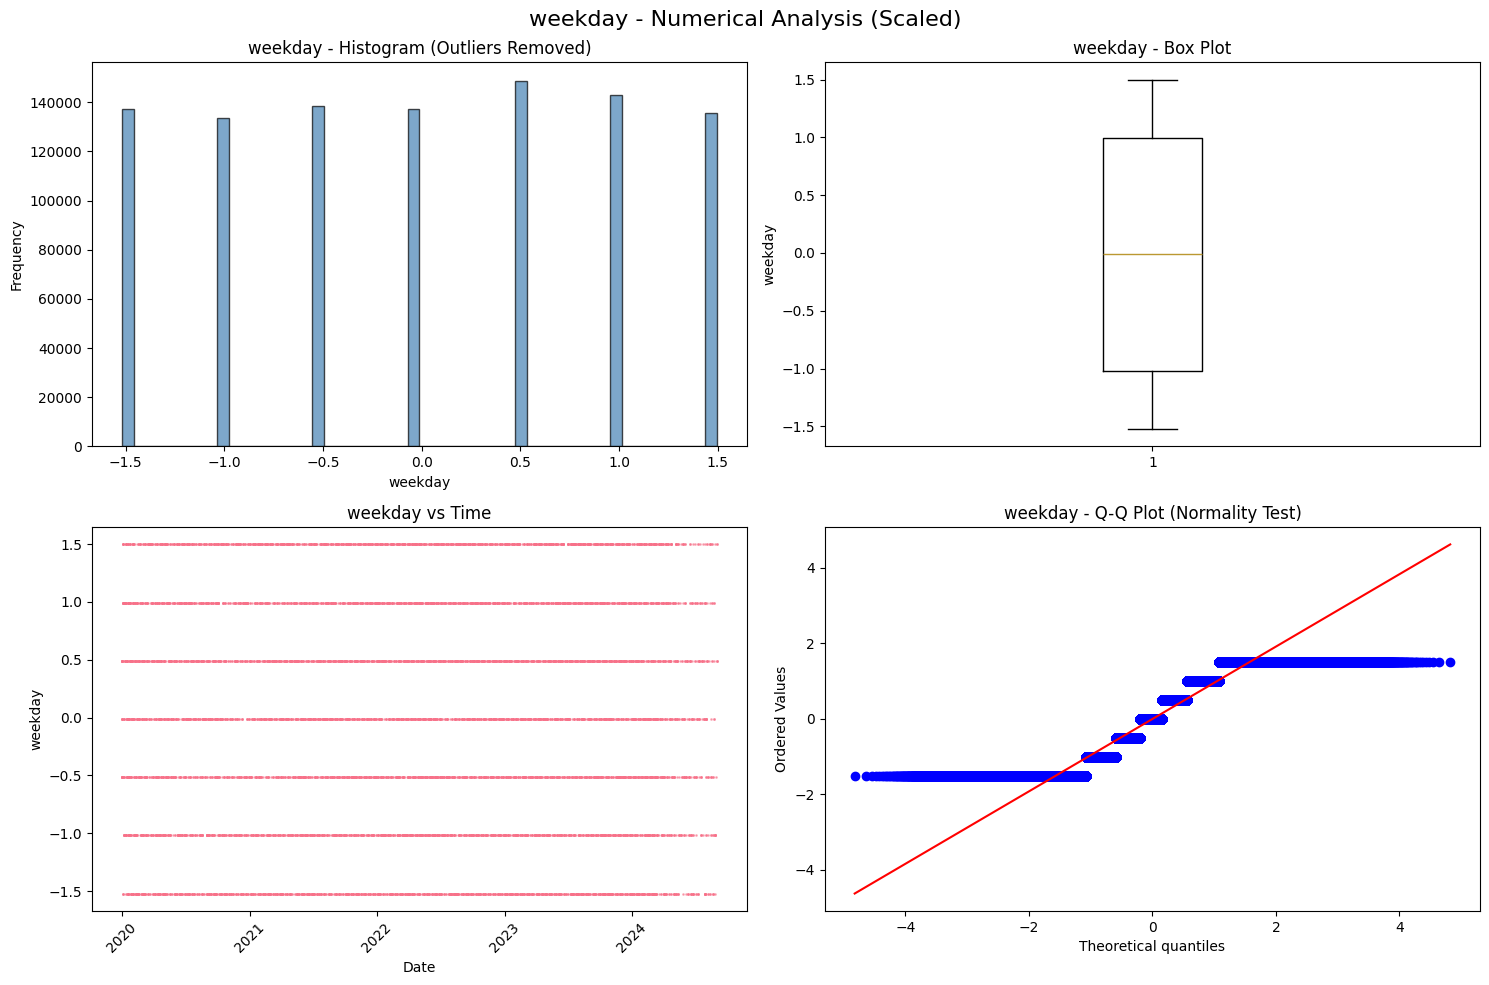


weekday Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.01
  Std: 1.00
  Min: -1.52
  Max: 1.50
  Missing: 0
  Outliers (IQR method): 0


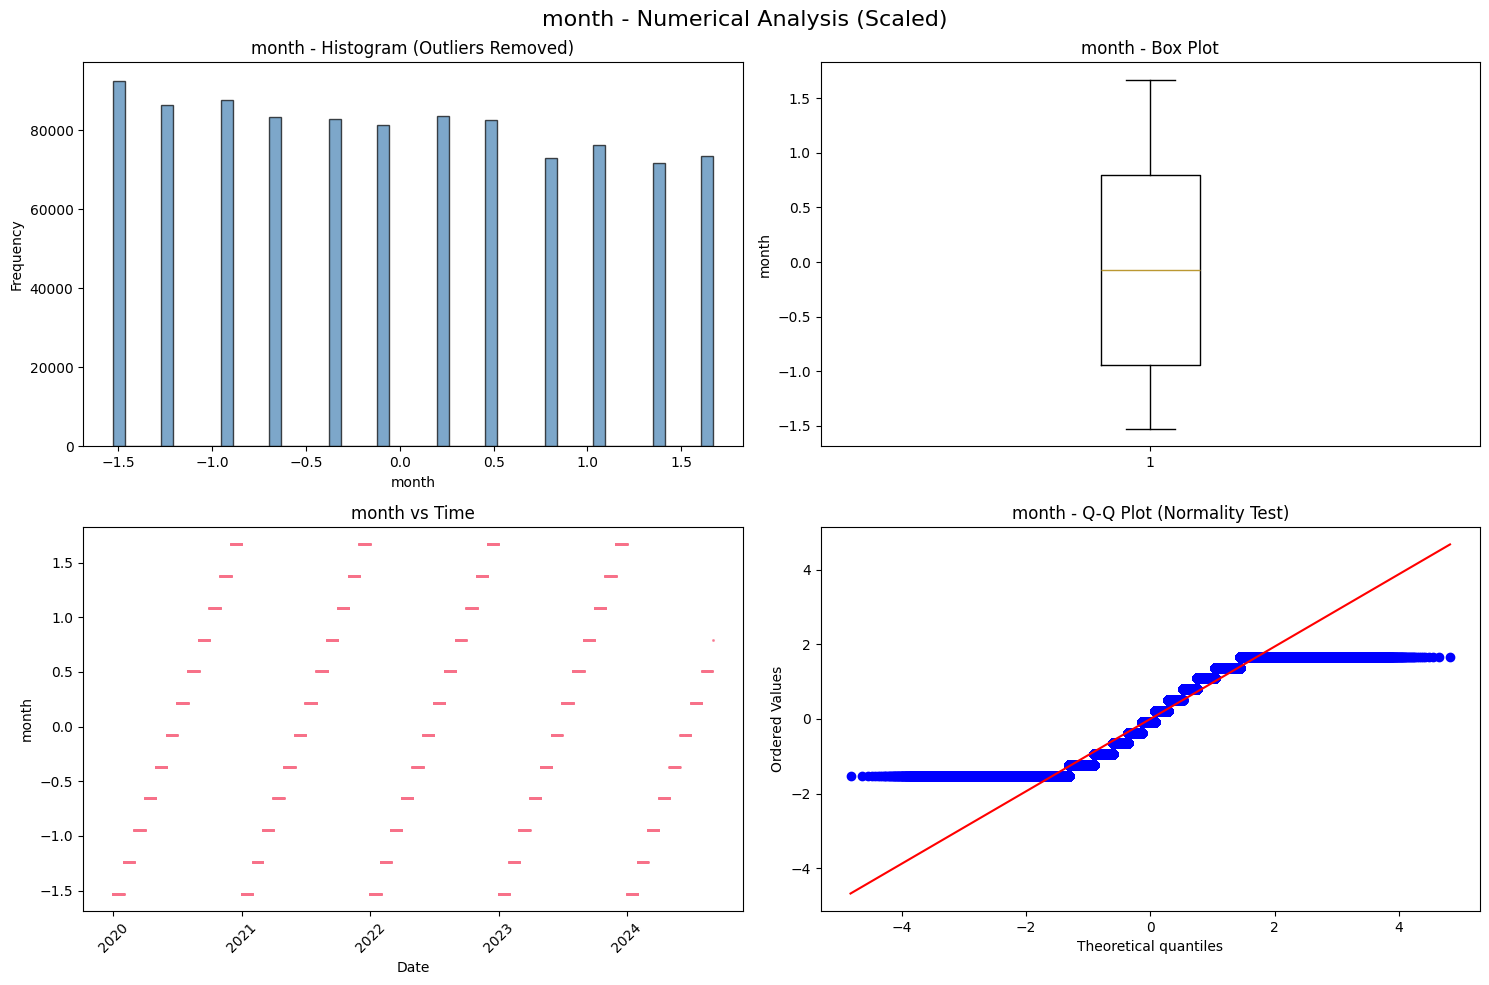


month Statistics (Scaled):
  Count: 974477
  Mean: -0.00
  Median: -0.07
  Std: 1.00
  Min: -1.53
  Max: 1.67
  Missing: 0
  Outliers (IQR method): 0


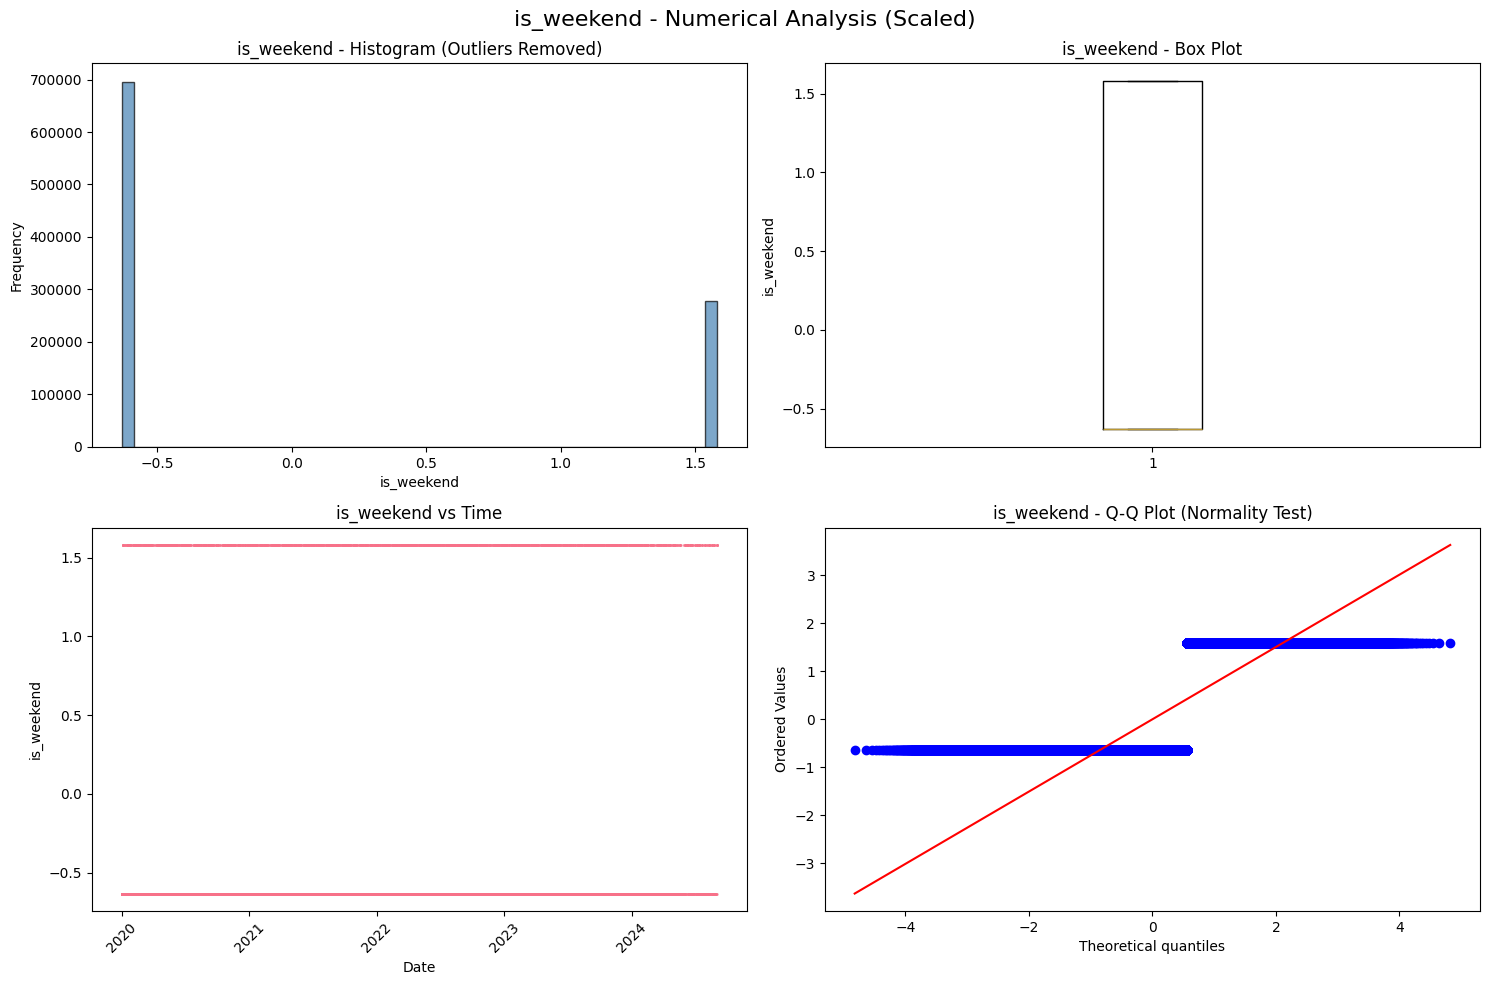


is_weekend Statistics (Scaled):
  Count: 974477
  Mean: 0.00
  Median: -0.63
  Std: 1.00
  Min: -0.63
  Max: 1.58
  Missing: 0
  Outliers (IQR method): 0

2. CORRELATION ANALYSIS (SCALED):


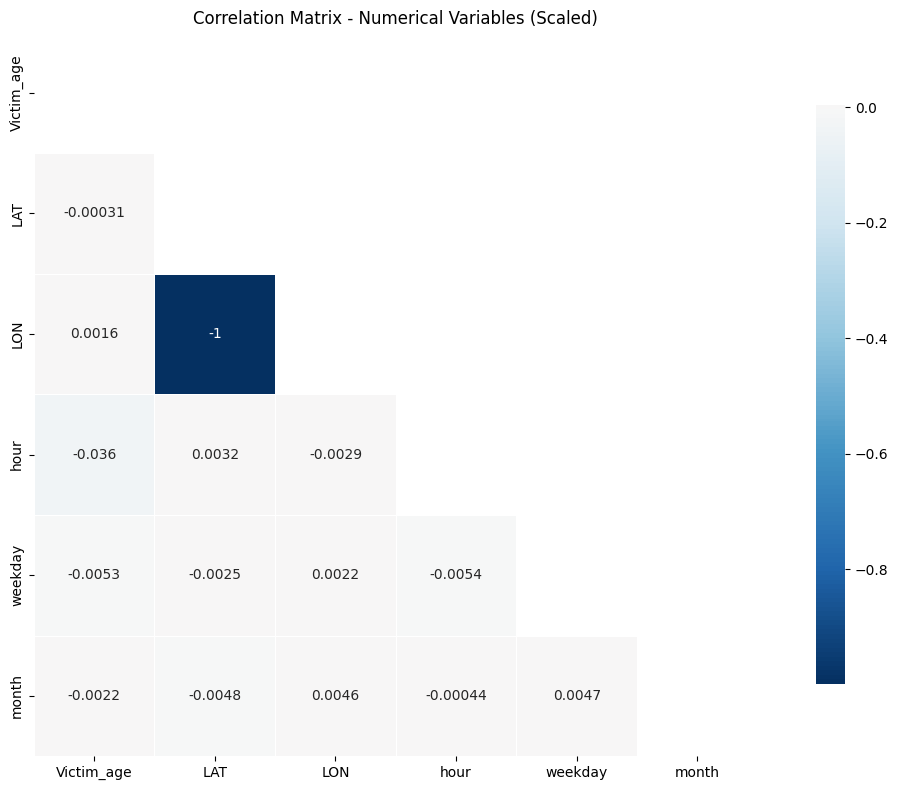


Strong Correlations (|r| > 0.5) (Scaled):
  LAT ↔ LON: -0.998

=== ANALYSIS COMPLETE (SCALED DATA) ===
📊 All distribution plots generated for scaled data!
📈 Check the correlation matrix for interesting relationships in scaled data
📋 Review the printed statistics for data quality insights on scaled data


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import ceil
from sklearn.preprocessing import StandardScaler

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

print("=== DISTRIBUTION ANALYSIS (SCALED DATA) ===\n")

# Identify numerical columns (assuming numerical_cols is already defined from previous steps)
if 'numerical_cols' not in locals():
    print("Error: 'numerical_cols' not found. Please run the previous cell to define it.")
else:
    # Apply Standard Scaler to numerical columns
    scaler = StandardScaler()
    df_scaled = df[numerical_cols].copy() # Create a copy to avoid modifying original df
    # Handle potential NaNs before scaling by imputing (e.g., with median or mean)
    # For simplicity, let's fill NaNs with the mean before scaling
    df_scaled = df_scaled.fillna(df_scaled.mean())
    df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])


    # ====== NUMERICAL DISTRIBUTIONS (Histograms + Scatter Plots) ======
    print("\n1. NUMERICAL DISTRIBUTIONS (SCALED):")

    def plot_numerical_distribution(col):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{col} - Numerical Analysis (Scaled)', fontsize=16)

        # Remove outliers for better visualization (using IQR on scaled data)
        Q1 = df_scaled[col].quantile(0.25)
        Q3 = df_scaled[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_data = df_scaled[col][(df_scaled[col] >= lower_bound) & (df_scaled[col] <= upper_bound)]

        # 1. Histogram
        axes[0, 0].hist(filtered_data.dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        axes[0, 0].set_title(f'{col} - Histogram (Outliers Removed)')
        axes[0, 0].set_xlabel(col)
        axes[0, 0].set_ylabel('Frequency')

        # 2. Box plot
        axes[0, 1].boxplot(df_scaled[col].dropna(), vert=True)
        axes[0, 1].set_title(f'{col} - Box Plot')
        axes[0, 1].set_ylabel(col)

        # 3. Scatter plot vs date (if date column exists in original df - scaling doesn't change dates)
        if 'date' in df.columns: # Use original df for date
             # Need to align scaled data with original dates
            temp_df = pd.DataFrame({col: df_scaled[col], 'date': df['date']})
            sample_data = temp_df.sample(min(10000, len(temp_df)))  # Sample for performance
            axes[1, 0].scatter(sample_data['date'], sample_data[col], alpha=0.5, s=1)
            axes[1, 0].set_title(f'{col} vs Time')
            axes[1, 0].set_xlabel('Date')
            axes[1, 0].set_ylabel(col)
            axes[1, 0].tick_params(axis='x', rotation=45)
        else:
             axes[1, 0].set_title('Date column not available')


        # 4. Q-Q plot for normality check
        from scipy import stats
        stats.probplot(filtered_data.dropna(), dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title(f'{col} - Q-Q Plot (Normality Test)')

        plt.tight_layout()
        plt.show()

        # Print detailed stats
        print(f"\n{col} Statistics (Scaled):")
        print(f"  Count: {df_scaled[col].count()}")
        print(f"  Mean: {df_scaled[col].mean():.2f}")
        print(f"  Median: {df_scaled[col].median():.2f}")
        print(f"  Std: {df_scaled[col].std():.2f}")
        print(f"  Min: {df_scaled[col].min():.2f}")
        print(f"  Max: {df_scaled[col].max():.2f}")
        print(f"  Missing: {df_scaled[col].isnull().sum()}")
        print(f"  Outliers (IQR method): {((df_scaled[col] < lower_bound) | (df_scaled[col] > upper_bound)).sum()}")

    # Plot numerical distributions
    for col in numerical_cols:
        if df_scaled[col].nunique() > 1 and df_scaled[col].notna().sum() > 0:
            plot_numerical_distribution(col)

    # ====== CORRELATION MATRIX FOR NUMERICAL COLUMNS ======
    print("\n2. CORRELATION ANALYSIS (SCALED):")

    # Select numerical columns with sufficient data
    corr_cols = [col for col in numerical_cols if df_scaled[col].notna().sum() > 100 and df_scaled[col].nunique() > 2]

    if len(corr_cols) > 1:
        plt.figure(figsize=(12, 8))
        correlation_matrix = df_scaled[corr_cols].corr()

        # Create correlation heatmap
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                    square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Correlation Matrix - Numerical Variables (Scaled)')
        plt.tight_layout()
        plt.show()

        # Print strong correlations
        print("\nStrong Correlations (|r| > 0.5) (Scaled):")
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.5:
                    col1, col2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
                    print(f"  {col1} ↔ {col2}: {corr_val:.3f}")
    else:
        print("Not enough numerical columns with sufficient data to compute correlation.")


    print("\n=== ANALYSIS COMPLETE (SCALED DATA) ===")
    print("📊 All distribution plots generated for scaled data!")
    print("📈 Check the correlation matrix for interesting relationships in scaled data")
    print("📋 Review the printed statistics for data quality insights on scaled data")

#functions

In [20]:
# tools/base.py
def train_val_test_split(df, date_col="DATE", cutoff_train="2023-12-31",
                         cutoff_val="2024-06-30"):
    """Time-aware split (train 2020–2023, val H1-2024, test H2-2024)."""
    # implement time split logic...
    return df_train, df_val, df_test


In [21]:
# tools/dim_reduction.py
from sklearn.decomposition import PCA, NMF

def pca_features(X, n_components=10):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X), pca

def nmf_features(X, n_components=5):
    nmf = NMF(n_components=n_components, init="nndsvda", random_state=42)
    return nmf.fit_transform(X), nmf


In [22]:
# tools/clustering.py
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering

def kmeans_cluster(X, k):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    return labels, model

def dbscan_cluster(X, eps=0.5, min_samples=10):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X)
    return labels, model

def spectral_cluster(X, k):
    model = SpectralClustering(n_clusters=k, affinity="nearest_neighbors", random_state=42)
    labels = model.fit_predict(X)
    return labels, model


In [23]:
# tools/models.py
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

def logistic_model(X_train, y_train):
    model = LogisticRegression(max_iter=500, class_weight="balanced")
    model.fit(X_train, y_train)
    return model

def svm_model(X_train, y_train, kernel="rbf"):
    model = SVC(kernel=kernel, probability=True, class_weight="balanced")
    model.fit(X_train, y_train)
    return model

def mlp_model(X_train, y_train, hidden=(64,32)):
    model = MLPClassifier(hidden_layer_sizes=hidden, max_iter=200, random_state=42)
    model.fit(X_train, y_train)
    return model


In [24]:
# tools/deep.py
import torch
import torch.nn as nn

class LSTMHotspot(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # last timestep
        return out


In [25]:
# tools/eval.py
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_classification(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:,1] if hasattr(model,"predict_proba") else None
    return {
        "acc": accuracy_score(y, y_pred),
        "f1": f1_score(y, y_pred, average="macro"),
        "auc": roc_auc_score(y, y_prob) if y_prob is not None else None,
        "conf": confusion_matrix(y, y_pred)
    }


In [29]:
# =========================
# SELF-CONTAINED DRIVER
# =========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ---- 1) Helpers ----
def _coerce_datetime(df, date_col):
    # be generous about column name
    candidates = [date_col, 'DATE', 'date', 'Date', 'DATE_OCC', 'DATE OCC']
    for c in candidates:
        if c in df.columns:
            out = df.copy()
            out[c] = pd.to_datetime(out[c], errors='coerce', utc=True).dt.tz_convert(None)
            out = out.sort_values(c)
            return out, c
    raise ValueError(f"Could not find a date column among: {candidates}")

def train_val_test_split_timeaware(df, date_col="DATE",
                                   train_end="2023-12-31",
                                   val_end="2024-06-30"):
    df, dcol = _coerce_datetime(df, date_col)
    train = df[df[dcol] <= pd.Timestamp(train_end)]
    val   = df[(df[dcol] >  pd.Timestamp(train_end)) & (df[dcol] <= pd.Timestamp(val_end))]
    test  = df[df[dcol] >  pd.Timestamp(val_end)]
    if min(len(train), len(val), len(test)) == 0:
        raise ValueError(f"Empty split: sizes -> train={len(train)}, val={len(val)}, test={len(test)}. "
                         f"Check your date column and ranges.")
    return train, val, test, dcol

def make_feature_target(df, target_col, drop_cols=()):
    if target_col not in df.columns:
        raise ValueError(f"target_col '{target_col}' not found.")
    X = df.drop(columns=[target_col] + [c for c in drop_cols if c in df.columns])
    y = df[target_col]
    # basic auto-dtype selection
    cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]
    num_cols = [c for c in X.columns if c not in cat_cols]
    return X, y, num_cols, cat_cols

def build_classifier_pipeline(num_cols, cat_cols):
    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
    ])
    cat_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=5))
    ])
    pre = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ])
    clf = LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=None)
    pipe = Pipeline([
        ("pre", pre),
        ("clf", clf),
    ])
    return pipe

def evaluate_classification(model, X, y, label=""):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1m = f1_score(y, y_pred, average="macro")
    print(f"[{label}] acc={acc:.4f}  macro-F1={f1m:.4f}")
    return {"acc": acc, "f1_macro": f1m, "report": classification_report(y, y_pred)}

# ---- 2) Driver ----
def run_task(task, df,
             date_col="DATE",
             # choose your target & drops based on your EDA/prep
             target_col="target_category",
             drop_cols=("LAT", "LON", "LOCATION", "DR_NO")):
    """
    task: "crime_classification" (baseline logistic)
    df: your preprocessed DataFrame (after your EDA/prep steps)
    date_col: name of the date column (auto-detected if common LAPD names)
    target_col: name of the label column (e.g., your 3-way category)
    drop_cols: columns to remove from X (IDs/coords/free text you don't want)
    """
    if task != "crime_classification":
        raise ValueError(f"Unknown task '{task}'. Supported: 'crime_classification'.")

    # time-aware splits (2020–2023 / H1 2024 / H2 2024)
    train_df, val_df, test_df, dcol = train_val_test_split_timeaware(df, date_col=date_col)

    # features/labels
    X_train, y_train, num_cols, cat_cols = make_feature_target(train_df, target_col, drop_cols)
    X_val,   y_val,   _,        _       = make_feature_target(val_df,   target_col, drop_cols)
    X_test,  y_test,  _,        _       = make_feature_target(test_df,  target_col, drop_cols)

    # pipeline + fit
    pipe = build_classifier_pipeline(num_cols, cat_cols)
    pipe.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))  # fit on train+val

    # eval
    m_val = evaluate_classification(pipe, X_val,  y_val,  label="VAL")
    m_tst = evaluate_classification(pipe, X_test, y_test, label="TEST")
    return {"val": m_val, "test": m_tst, "date_col_used": dcol, "num_cols": num_cols, "cat_cols": cat_cols}
